In [ ]:
!pip install tensorflow==2.3

In [ ]:
!pip install imgaug==0.4

     |████████████████████████████████| 952kB 9.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 44.9MB 63kB/s 


In [ ]:
#import libraries
import os
import numpy as np
import skimage.io as io
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import glob
import glob2 
##mod unet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras
import keras.backend as K
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum

from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from medpy.io import load
import numpy as np

#import cv2
import nibabel as nib
from PIL import Image
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EXPLORATORY DATA ANALYSIS


In [ ]:
#TRAINING FILES
#LGG FILES
all_seg_files_lgg = glob2.glob('/content/training/LGG/**/*seg.nii.gz')
all_lgg_files=glob2.glob('/content/training/LGG/**/*.nii.gz')
training_lgg_files=[]
for i in all_lgg_files:
  if "_seg" not in i.split("/")[-1]:
    training_lgg_files.append(i)

#HGG FILES
all_seg_files_hgg = glob2.glob('/content/training/HGG/**/*seg.nii.gz')
all_hgg_files=glob2.glob('/content/training/HGG/**/*.nii.gz')
training_hgg_files=[]
for i in all_hgg_files:
  if "_seg" not in i.split("/")[-1]:
    training_hgg_files.append(i)

total_no_lgg_imgvolumes=len(training_lgg_files)
print("LGG VOLUMES",total_no_lgg_imgvolumes)
output_masks_lgg=len(all_seg_files_lgg)
print("LGG MASKS",output_masks_lgg)

total_no_hgg_imgvolumes=len(training_hgg_files)
print("HGG VOLUMES",total_no_hgg_imgvolumes)
output_masks_hgg=len(all_seg_files_hgg)
print("HGG MASKS",output_masks_hgg) 

LGG VOLUMES 300
LGG MASKS 75
HGG VOLUMES 840
HGG MASKS 210


In [ ]:
#observations
#Here there are two types of image volumes -LGG and HGG
#There are 4 types of modalities in each type of Lgg and Hgg volumes of each patient
#There are 300 LGG volumes and 75 LGG masks
#There are 840 HGG volumes and 210 HGG masks
#for each patient,there are 4 modalities and segmentation mask (ground truth label)


In [ ]:
#VALIDATION FILES
all_val_files = glob2.glob("/content/validation/**/*nii.gz")
print("VALIDATION FILES ",len(all_val_files))

VALIDATION FILES  264


In [ ]:
#There are 264 validation files provided by the dataset(there is no specific lgg and hgg files seperately given)

In [ ]:
os.listdir("/content/training/LGG/Brats18_TCIA13_654_1/")
os.listdir("/content/training/HGG/Brats18_CBICA_AMH_1/") 

['Brats18_CBICA_AMH_1_seg.nii.gz',
 'Brats18_CBICA_AMH_1_t1ce.nii.gz',
 'Brats18_CBICA_AMH_1_t2.nii.gz',
 'Brats18_CBICA_AMH_1_t1.nii.gz',
 'Brats18_CBICA_AMH_1_flair.nii.gz']

In [ ]:
#for each patient,there are 4 modalities and one segmentation mask 

In [ ]:
#to read each image volume as array
##lgg modalities
imglgg_flair = io.imread("/content/training/LGG/Brats18_TCIA13_654_1/Brats18_TCIA13_654_1_flair.nii.gz", plugin='simpleitk')
imglgg_t1=io.imread("/content/training/LGG/Brats18_TCIA13_654_1/Brats18_TCIA13_654_1_t1.nii.gz", plugin='simpleitk')
imglgg_t1ce=io.imread("/content/training/LGG/Brats18_TCIA13_654_1/Brats18_TCIA13_654_1_t1ce.nii.gz", plugin='simpleitk')
imglgg_t2=io.imread("/content/training/LGG/Brats18_TCIA13_654_1/Brats18_TCIA13_654_1_t2.nii.gz", plugin='simpleitk')

#hgg modalities
imghgg_flair = io.imread("/content/training/HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_flair.nii.gz", plugin='simpleitk')
imghgg_t1=io.imread("/content/training/HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t1.nii.gz", plugin='simpleitk')
imghgg_t1ce=io.imread("/content/training/HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t1ce.nii.gz", plugin='simpleitk')
imghgg_t2=io.imread("/content/training/HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t2.nii.gz", plugin='simpleitk')


In [ ]:
#lgg
print("shape of each modality of lgg",imglgg_flair.shape)

#hgg
print("shape of each modality of hgg",imghgg_flair.shape)

shape of each modality of lgg (155, 240, 240)
shape of each modality of hgg (155, 240, 240)


In [ ]:
#Dimensions of the image volume=(depth,height,width)
#here depth/no.of slices that can be done=155
#height=240,width=240

In [ ]:
#different views of image volumes of each modality of lgg and hgg
image_hgg_modalities=[imghgg_flair,imghgg_t1,imghgg_t1ce,imghgg_t2]
image_lgg_modalities=[imglgg_flair,imglgg_t1,imglgg_t1ce,imglgg_t2]

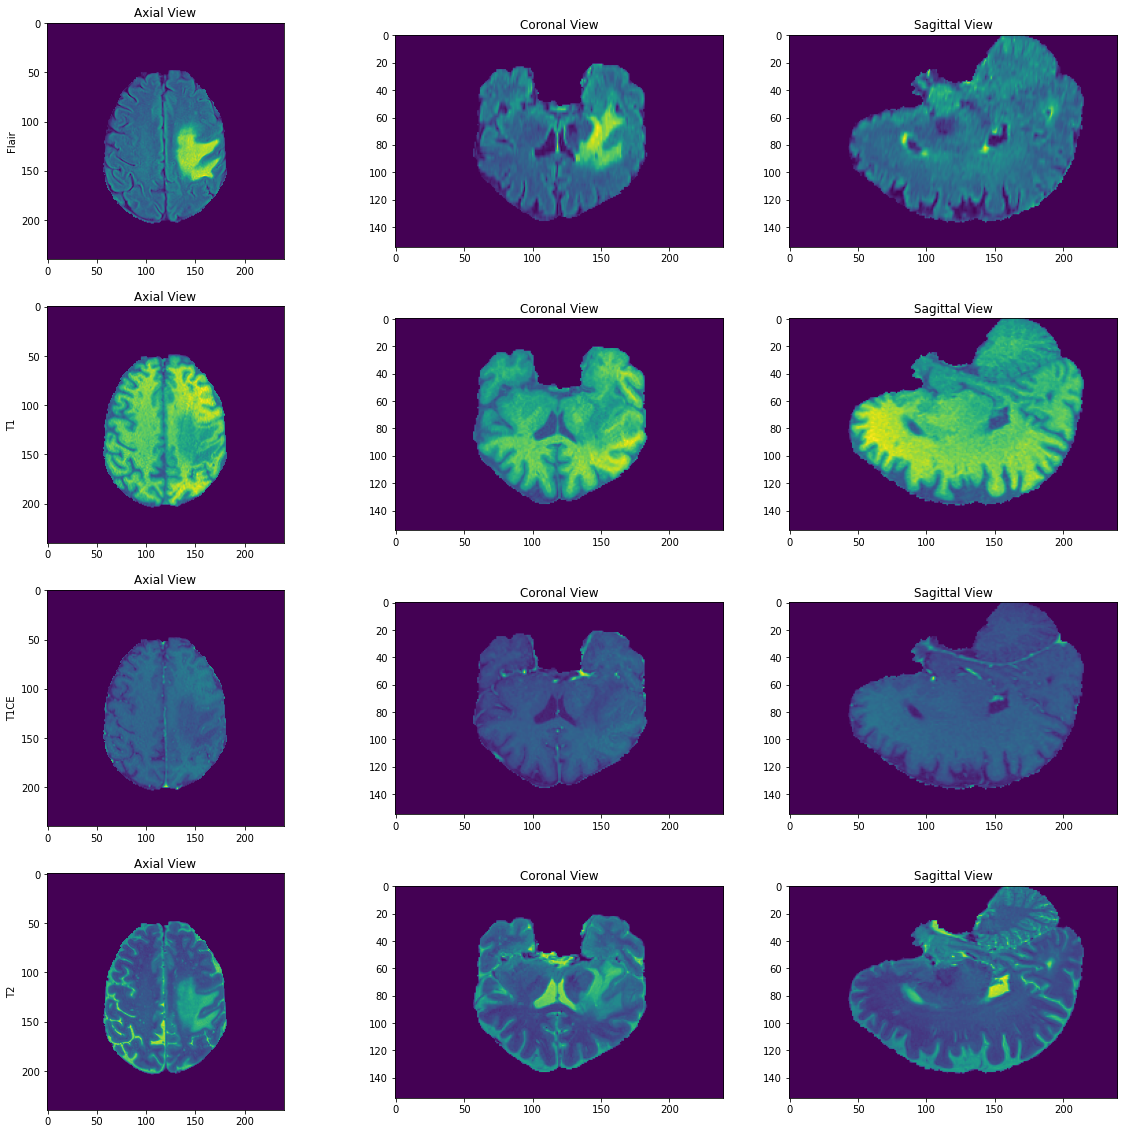

In [ ]:
#visualization of a slice of each modality in different views of lgg and hgg 
#there are 3 different views of a slice there are Axial,coronal,saggital view

#hgg modalities
k=1
plt.figure(figsize=(20,20))
for l,i in enumerate(image_hgg_modalities):
  for j in range(3):
    if (j==0):
      plt.subplot(4,3,k)
      plt.imshow(i[100,:,:])
      plt.title("Axial View")
      if(l==0):
        plt.ylabel("Flair")
      if(l==1):
        plt.ylabel("T1")
      if(l==2):
        plt.ylabel("T1CE")
      if(l==3):
        plt.ylabel("T2")

      k=k+1
    elif (j==1):
      plt.subplot(4,3,k)
      plt.imshow(i[:,100,:])
      plt.title("Coronal View")
      k+=1
    else:
      plt.subplot(4,3,k)
      plt.imshow(i[:,:,100])
      plt.title("Sagittal View")
      k+=1
 .


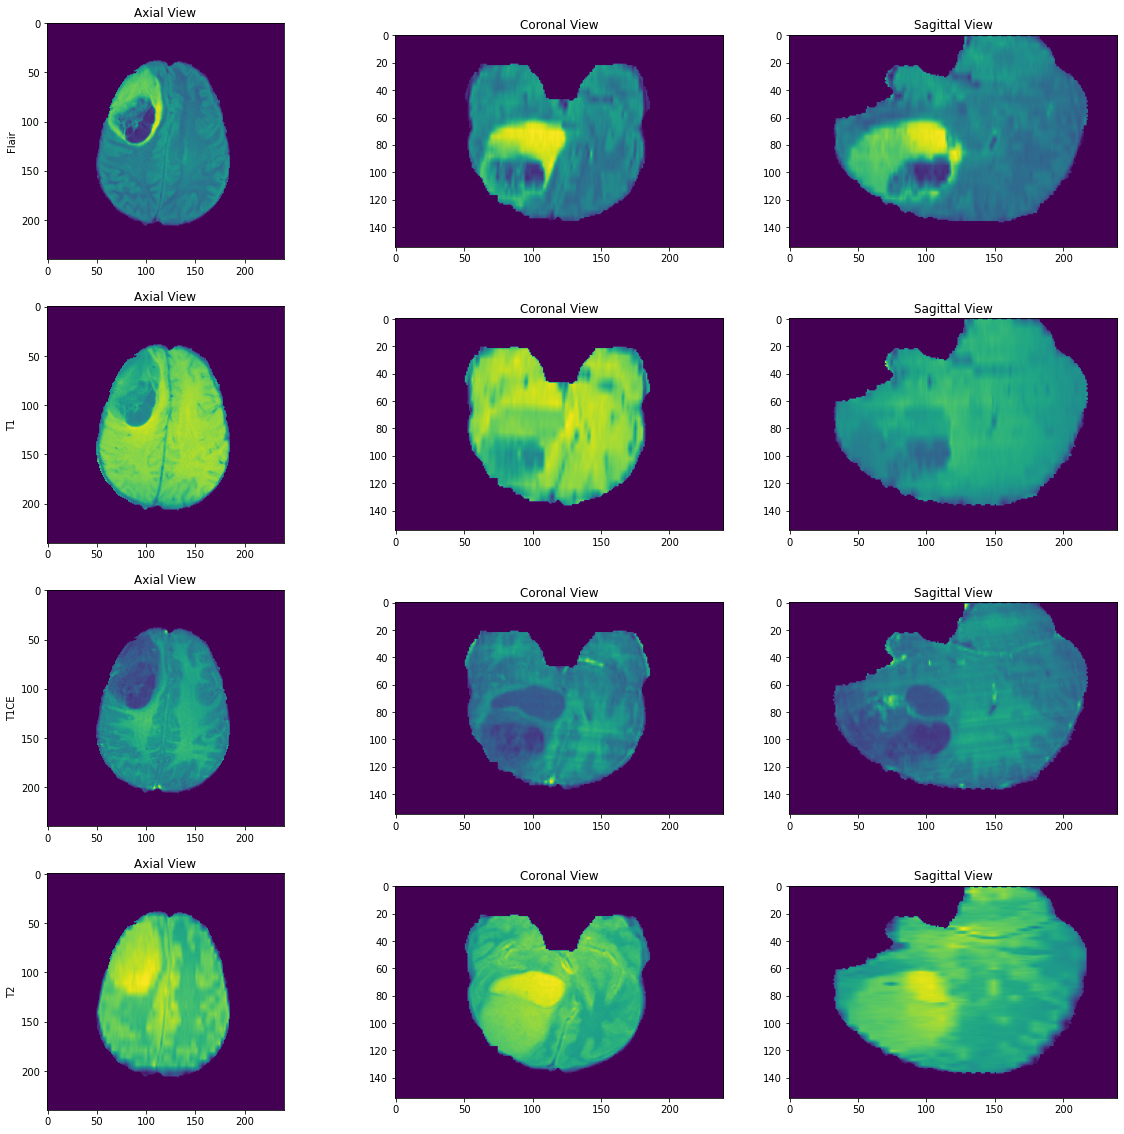

In [ ]:
#lgg modalities
k=1
plt.figure(figsize=(20,20))
for l,i in enumerate(image_lgg_modalities):
  for j in range(3):
    if (j==0):
      plt.subplot(4,3,k)
      plt.imshow(i[100,:,:])
      plt.title("Axial View")
      if(l==0):
        plt.ylabel("Flair")
      if(l==1):
        plt.ylabel("T1")
      if(l==2):
        plt.ylabel("T1CE")
      if(l==3):
        plt.ylabel("T2")

      k=k+1
    elif (j==1):
      plt.subplot(4,3,k)
      plt.imshow(i[:,100,:])
      plt.title("Coronal View")
      k+=1
    else:
      plt.subplot(4,3,k)
      plt.imshow(i[:,:,100])
      plt.title("Sagittal View")
      k+=1

In [ ]:
os.listdir("/content/HGG/Brats18_CBICA_AMH_1") 

['Brats18_CBICA_AMH_1_flair.nii.gz',
 'Brats18_CBICA_AMH_1_t1.nii.gz',
 'Brats18_CBICA_AMH_1_seg.nii.gz',
 'Brats18_CBICA_AMH_1_t1ce.nii.gz',
 'Brats18_CBICA_AMH_1_t2.nii.gz']

In [ ]:
#to read segmentation mask/ground truth label of a patient of hgg and lgg

imglgg_seg=io.imread("/content/LGG/Brats18_TCIA10_387_1/Brats18_TCIA10_387_1_seg.nii.gz", plugin='simpleitk')
imghgg_seg=io.imread("/content/HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_seg.nii.gz", plugin='simpleitk')

In [ ]:
print("GROUND TRUTH LABEL/MASK SHAPE OF LGG",imglgg_seg.shape)
print("GROUND TRUTH LABEL/MASK SHAPE OF HGG",imghgg_seg.shape)

GROUND TRUTH LABEL/MASK SHAPE OF LGG (155, 240, 240)
GROUND TRUTH LABEL/MASK SHAPE OF HGG (155, 240, 240)


In [ ]:
#Here the shape of segmentation mask of lgg and hgg is (155,240,240)
#depth=155

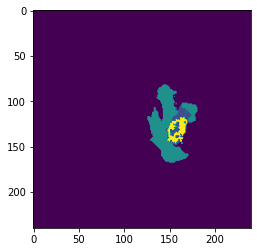

In [ ]:
plt.imshow(imghgg_seg[75,:,:])

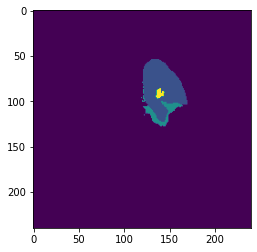

In [ ]:
plt.imshow(imglgg_seg[100,:,:])

In [ ]:
unique_labels_hgg=np.unique(imghgg_seg[75,:,:])
unique_labels_lgg=np.unique(imglgg_seg[100,:,:])

print("UNIQUE LABELS OF HGG",unique_labels_hgg)
print("UNIQUE LABELS OF LGG",unique_labels_lgg)

UNIQUE LABELS OF HGG [0 1 2 4]
UNIQUE LABELS OF LGG [0 1 2 4]


In [ ]:
#There are 4 labels for segmentation mask/ground truth
# only tumor part is visble and segmented by 3 labels(green,yellow,blue) and another label is background (purple)

In [ ]:
## to check for class imbalances in data for either lgg/hgg 

#converted to one dimension
imghgg_seg.reshape(-1,1).shape

#converted to series data to plot value counts of each class
a=pd.Series(list(imghgg_seg.reshape(-1,1)))
b=a.value_counts()
print(b)

[0]    8802713
[2]     107610
[4]       9002
[1]       8675
dtype: int64


In [ ]:
#observation:
#here we can observe that there are more no.of class0 labels which are non-tumorous
#so there is a high class imbalance in the data 

In [ ]:
b.index=[0,2,4,1]

In [ ]:
b

0    8802713
2     107610
4       9002
1       8675
dtype: int64

In [ ]:
#calculated the percentage of class labels and stored them in the dictionary
x={}
for i in b.index:
  x[i]=b[i]/sum(b.values)

In [ ]:
x

{0: 0.9859669578853046,
 1: 0.0009716621863799283,
 2: 0.012053091397849462,
 4: 0.0010082885304659498}

In [ ]:
#visualization of class labels using a bar plot

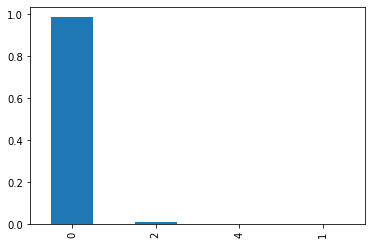

In [ ]:
pd.Series(x).plot(kind='bar')

In [ ]:
#to plot histogram of pixel intensities of a modality hgg and lgg volume 
#to check whether they follow similar pixel distribution or not and also to check if any outliers present

def plot_hist(img):
  img2=img.reshape(-1,1)
  plt.hist(img2)
  img3=pd.Series(list(img2))
  img4=img3.value_counts()

  return img4

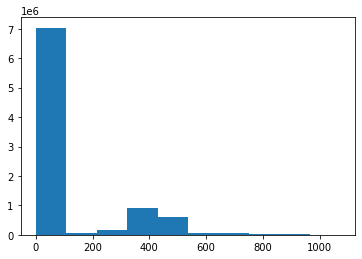

In [ ]:
#histogram for lgg 
imglgg_flair_counts=plot_hist(imglgg_flair)

In [ ]:
imglgg_flair_counts

[0]       7006363
[395]       10181
[403]       10127
[394]       10079
[401]       10072
           ...   
[1007]          1
[1072]          1
[1052]          1
[1006]          1
[997]           1
Length: 1004, dtype: int64

In [ ]:
#observation
# most of the pixel values are zero
#and pixel values are right skewed
# wen can also observe that pixel values arearound 0 and some of the pixels distrubuted around 400
#and there are outliers as there are very few valuesof pixels with intensity after 500
#there is lot of variation in single volume
#we need to normalize so as to deal with skewness

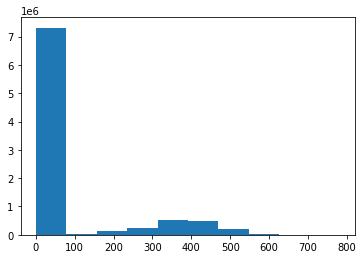

In [ ]:
#similary done for lgg of t1 modality
imghgg_t1_counts=plot_hist(imghgg_t1)


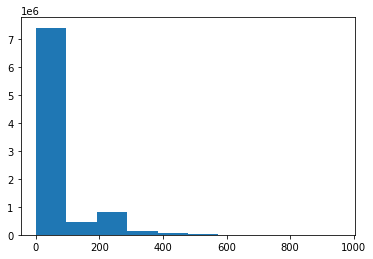

In [ ]:
#histogram for hgg 
imghgg_flair_counts=plot_hist(imghgg_flair)

In [ ]:
# most of the pixel values are zero
#and pixel values are right skwed
# wen can also observe that pixel values arearound 0 and some of the pixels distrubuted around 200
#and there are outliers as there are very few valuesof pixels with intensity after 300
#there is lot of variation in single volume
#we need to normalize so as to deal with skewness


In [ ]:
#correlation matrix
#to check the correlation between slices along the depth of the image of hgg and lgg volume 

#for hgg volume
#iterated with the depth of the image and taken slices so as to calculate correlation between slices
#converted each slice pixel values into list of values(1 dimensional)
p=[]
for i in range(imghgg_flair.shape[0]):
    slice_=list(imghgg_flair[i,:,:].reshape(-1,1))
    p.append(slice_)

In [ ]:
# converted slices pixel values into data frame so that each column represent a slice pixel values
p_=np.array(p)
m=p_.reshape(155,57600).T

print(m.shape)
n=pd.DataFrame(m)

(57600, 155)


In [ ]:
n.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#no.of missing values 
n.isna().sum().value_counts()

0    155
dtype: int64

In [ ]:
#to check correlation of each column/slice 
n.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154
0,1.000000,0.918879,0.834216,0.756760,0.688122,0.643113,0.609584,0.584395,0.564727,0.544120,0.527516,0.517485,0.507250,0.492340,0.477997,0.464122,0.451506,0.443284,0.436190,0.427970,0.417649,0.401884,0.385675,0.371044,0.359222,0.350614,0.340804,0.331154,0.323606,0.320182,0.323552,0.326520,0.331252,0.331543,0.325624,0.314199,0.300224,0.286981,0.278683,0.273070,...,0.274887,0.282330,0.289130,0.295341,0.301652,0.311074,0.322537,0.332875,0.336685,0.340329,0.338784,0.330862,0.325542,0.320228,0.320384,0.316765,0.305019,0.292330,0.268384,0.221741,0.191178,0.141573,0.116329,0.027416,-0.006171,-0.001437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.918879,1.000000,0.931031,0.860411,0.789869,0.741306,0.702770,0.673995,0.651230,0.626817,0.606081,0.593757,0.581367,0.564618,0.548742,0.532113,0.516957,0.506434,0.499026,0.491070,0.480019,0.462399,0.443747,0.427640,0.415491,0.406134,0.395345,0.384335,0.374901,0.369776,0.372666,0.375449,0.380165,0.379323,0.371926,0.359007,0.342420,0.326785,0.316239,0.309062,...,0.319488,0.327806,0.335457,0.341943,0.348078,0.356009,0.366839,0.376080,0.377022,0.378588,0.377690,0.368925,0.362383,0.354646,0.352862,0.347599,0.333497,0.315722,0.287702,0.241343,0.207492,0.155901,0.119970,0.030860,-0.007113,-0.001656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.834216,0.931031,1.000000,0.938927,0.874926,0.827611,0.785233,0.751697,0.725346,0.698500,0.675980,0.661815,0.647368,0.628767,0.611332,0.592456,0.575319,0.564353,0.557179,0.549347,0.537071,0.517363,0.496027,0.477016,0.463073,0.452159,0.440551,0.428951,0.418929,0.413257,0.415410,0.416724,0.420410,0.418609,0.409727,0.395131,0.376491,0.359424,0.347444,0.338521,...,0.355907,0.364299,0.371512,0.378177,0.384283,0.392751,0.403222,0.410598,0.410494,0.411736,0.411236,0.398090,0.390042,0.383012,0.377668,0.368520,0.349591,0.329596,0.298320,0.251898,0.221564,0.170932,0.127450,0.042631,0.021013,-0.001839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.756760,0.860411,0.938927,1.000000,0.951280,0.909953,0.866546,0.829668,0.799499,0.768700,0.742421,0.726148,0.710031,0.690062,0.671693,0.651257,0.632745,0.621972,0.615060,0.607689,0.594718,0.573995,0.550691,0.528260,0.511296,0.497314,0.484399,0.472417,0.461685,0.455452,0.456717,0.457417,0.459604,0.455167,0.443799,0.426831,0.407184,0.389691,0.377372,0.367088,...,0.390966,0.399813,0.407753,0.416161,0.421863,0.429045,0.437354,0.441206,0.439526,0.439210,0.434153,0.417915,0.409193,0.401431,0.393709,0.381648,0.360791,0.340270,0.308191,0.262957,0.234562,0.189471,0.141347,0.054004,0.029791,-0.002015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.688122,0.789869,0.874926,0.951280,1.000000,0.966768,0.924988,0.884349,0.853760,0.821497,0.793355,0.775980,0.759022,0.739041,0.720038,0.698765,0.679517,0.667269,0.658123,0.648387,0.635315,0.615093,0.591340,0.566604,0.547457,0.531713,0.518011,0.506512,0.496791,0.494890,0.499524,0.502037,0.498886,0.486957,0.469103,0.449338,0.429056,0.411252,0.398669,0.387786,...,0.415054,0.424655,0.433872,0.443170,0.448232,0.452887,0.454154,0.455888,0.453758,0.451229,0.444206,0.427250,0.418204,0.406868,0.395461,0.380444,0.358212,0.335279,0.303117,0.260122,0.234503,0.196749,0.145951,0.061101,0.032003,-0.002151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
#observation
#If the values of the ith or jth feature/slice do not vary, 
#then the respective standard deviation will be zero and so will the denominator of the fraction. Thus, the correlation will be NaN
#here from above table141th slice there is no variation in the pixel value,so these slices after 141 are not useful for further process


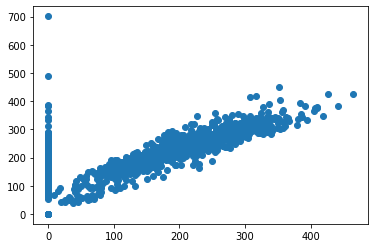

In [ ]:
#visualization of correlation between successive slices using scatter plot
#slices of 0 &1
plt.scatter(n[0],n[1])

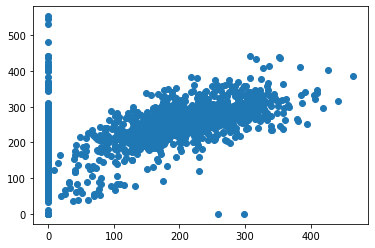

In [ ]:
#slices of 0&2
plt.scatter(n[0],n[2])

In [ ]:
#observation
#for every slice there is strong coreleation between 2 or 3 slice around that slice.
#for example 0th slice is having strong correlation to,1 ,2,3.and 4th slice having correlation to 3,5,6

# DATA PRE PROCESSING 

In [ ]:
#creating new directories for storing hgg and lgg files
#hgg
os.makedirs("new_data") 
os.makedirs("new_data/FLAIR_HGG")
os.makedirs("new_data/MASK_HGG")
os.makedirs("new_data/T1_HGG")
os.makedirs("new_data/T1CE_HGG")
os.makedirs("new_data/T2_HGG")

#lgg

os.makedirs("new_data/FLAIR_LGG")
os.makedirs("new_data/MASK_LGG")
os.makedirs("new_data/T1_LGG")
os.makedirs("new_data/T1CE_LGG")
os.makedirs("new_data/T2_LGG")

In [ ]:
def bias_field_correction(image_path,output_path):
  """
  Before giving to the pre-processing stage the raw data and is bias corrected as this 
  bias signal is a very low frequency signal and smooth which will corrupt the mri image which will be difficult for 
  image segmentation algorithms to process the images

  Function Parameters:
  --------------------
  image_path: path of the image 
  output_path : corrected output path of image 

  """
    img = sitk.ReadImage(image_path)
    img_mask = sitk.OtsuThreshold(img)
    img = sitk.Cast(img, sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    img_c = corrector.Execute(img, img_mask)
    sitk.WriteImage(img_c,output_path)

In [ ]:
def noise_removal_data(source,patients,grade):

    """
  This functions performs the removal of bias signal from image volumes of lgg and hgg
  Input:
  source:Directory of patients image volumes of lgg and hgg
  patients:list of paths of patients directories
  grade:lgg type or hgg type volume
  
  """
  for patient in patients:
    #looping through modality of patients image volumes
    modalities=os.listdir(source+"/"+patient)
    v=[]
    
    for seq in modalities:
      #looping for each sequence of modalities of a patient
        #for FLAIR sequence
        if ("flair" in seq):
            #print(source+'/'+patient+'/'+seq)
            #print('FLAIR_LGG/'+patient+'/'+seq)
            bias_field_correction(source+'/'+patient+'/'+seq,'new_data/FLAIR_'+grade+'/'+seq)
        
 
        #t1 sequence
        if (("t1" in seq) and ("t1ce" not in seq)):
        
            bias_field_correction(source+'/'+patient+'/'+seq,'new_data/T1_'+grade+'/'+seq)
            
            
    
        #for T1CE sequence
        if ("t1ce" in seq):
            
            bias_field_correction(source+'/'+patient+'/'+seq,'new_data/T1CE_'+grade+'/'+seq)
            

          

        #for T2 sequence        
        if ("t2" in seq):
            
            bias_field_correction(source+'/'+patient+'/'+seq,'new_data/T2_'+grade+'/'+seq)
        

        
source_lgg="training/LGG"
source_hgg="training/HGG"
patients_lgg=os.listdir(source_lgg)
patients_hgg=os.listdir(source_hgg)
noise_removal_data(source_lgg,patients_lgg,'LGG')
noise_removal_data(source_hgg,patients_hgg,'HGG')

In [ ]:
def preprocessing(image_volume):
  """
  This function is used to preprocess the given corrected image volume of lgg ang hgg
  1.perform standardization for non zero pixels in array
  2.clipping image to range [-5,5]
  3.Normalizing non brain region pixels 

  Function Parameters:
  Image_volume: Input image volume of lgg or hgg

  Returns:
  scaled_image:pre-processed image volume
  """

    #compute std dev and mean for non zero elements in array
    #standardization
    std_dev=np.std(image_volume[np.nonzero(image_volume)])
    mean=np.mean(image_volume[np.nonzero(image_volume)])
    stdzn=(image_volume-mean)/std_dev
    
    #clipping the image to range [-5,5]
    clip_=np.clip(stdzn,-5,5)
    #to set non brain region to 0 before passing it to normalization
    mask_=(image_volume!=0)
    
    #after rescaling,multiply the rescaled image with mask to get image which has non brain region as 0

    rescaled_image=(clip_ - clip_.min()) / (clip_.max() - clip_.min())
    
    rescaled_image=mask_*rescaled_image
    
    return rescaled_image

In [ ]:
#to take a threshold for min.no of non zero pixels 

a=io.imread("training/HGG/Brats18_2013_2_1/Brats18_2013_2_1_flair.nii.gz", plugin='simpleitk')
min_nonzeros=np.count_nonzero(a[18])

In [ ]:
#creating new directory to collect slices of lgg and hgg
os.makedirs("new_data_slices")
#hgg
os.makedirs("new_data_slices/FLAIR_LGG")
os.makedirs("new_data_slices/T1_LGG")
os.makedirs("new_data_slices/T1CE_LGG")
os.makedirs("new_data_slices/T2_LGG")
os.makedirs("new_data_slices/MASK_LGG")
#lgg
os.makedirs("new_data_slices/FLAIR_LGG")
os.makedirs("new_data_slices/T1_LGG")
os.makedirs("new_data_slices/T1CE_LGG")
os.makedirs("new_data_slices/T2_LGG")
os.makedirs("new_data_slices/MASK_LGG")

In [ ]:
def create_slices(grade_type,modality,grade,collected=False,b=[]):

    """
    This function create slices of an image volume
    Function parameters:
    ---------------------
     grade_type: list of image volumes of type of grade
     modality:type of image sequences -FLAIR,T1,T1CE,T2,MASK
     grade:HGG or LGG
     collected: False:collects the slice indexes of image volumes which are useful to take same type of slices of all the sequences
     eg:if index 5  slice of a image flair volume is collected first then its same index is given to t1 so to get that particular slice of the same image volume
     likewise done for all slices and all image volumes of patients
     b=[]:It is empty when no slice index is taken

     Returns:
     --------
     b:slice indexes
    
    """
    
    count=0
    for image in grade_type:
        image_volume=io.imread("new_data/"+modality+"_"+grade+"/"+image, plugin='simpleitk')
        x=image.split('.')[0]

        patient=x.replace(x.split("_")[-1],"")
        #image_volume=preprocessing(image_volume)
        
        if (collected == False):
            v=[]
            for slice_ in range(image_volume.shape[0]):
                if (slice_%2==1) and (slice_<141):
                    if(np.count_nonzero(image_volume[slice_])>=min_nonzeros):
                        np.save("new_data_slices/"+modality+"_"+grade+"/"+patient+modality+"_"+str(slice_),image_volume[slice_].astype('float32')) 
                        v.append(slice_)
               
            b.append(v)
        
        else:
            
            while(count<len(b)):
            
           # image_volume=io.imread("new_data/"+modality+"_"+grade+"/"+image, plugin='simpleitk')
        
                
                for slice_other_modality in b[count]:
                    #print(slice_other_modality)
                    #break
                    val=image_volume[slice_other_modality]

                    np.save("new_data_slices/"+modality+"_"+grade+"/"+patient+modality+"_"+str(slice_other_modality),val.astype('float32'))
                count+=1
                break
                
    return b


In [ ]:
#unzipping the files where all slices are created for all image volumes
#here lgg files are taken 

In [ ]:
!unzip "/content/drive/My Drive/new_data_slices_lgg.zip"

Streaming output truncated to the last 5000 lines.
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_65.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_67.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_69.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_71.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_73.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_75.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_77.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_79.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_81.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_83.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_85.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_87.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_89.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_91.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_93.npy  
  inflating: FLAIR_LGG/Brats18_TCIA10_639_1_FLAIR_95.npy  
  inf

In [ ]:
#store these slices
flair_lgg=os.listdir("/content/FLAIR_LGG")
mask_lgg=os.listdir("/content/MASK_LGG")
t1ce_lgg=os.listdir("/content/T1CE_LGG")
t2_lgg=os.listdir("/content/T2_LGG")
t1_lgg=os.listdir("/content/T1_LGG")

flair_lgg.sort()
t1_lgg.sort()
t1ce_lgg.sort()
t2_lgg.sort()
mask_lgg.sort()

In [ ]:
flair_hgg=os.listdir("/content/FLAIR_HGG")
t1_hgg=os.listdir("/content/T1_HGG")
t2_hgg=os.listdir("/content/T2_HGG")
t1ce_hgg=os.listdir("/content/T1CE_HGG")
mask_hgg=os.listdir("/content/MASK_HGG")


flair_hgg.sort()
t1_hgg.sort()
t1ce_hgg.sort()
t2_hgg.sort()
mask_hgg.sort()

In [ ]:
#stores these files in array format -lgg
flair_l=[]
t1_l=[]
t2_l=[]
t1ce_l=[]
mask_l=[]
for a,b,c,d,e in zip(flair_lgg,t1_lgg,t2_lgg,t1ce_lgg,mask_lgg):
  l="/content/FLAIR_LGG/"+a
  m="/content/T1_LGG/"+b
  n="/content/T2_LGG/"+c
  o="/content/T1CE_LGG/"+d
  p="/content/MASK_LGG/"+e
  
  flair_l.append(l)
  t1_l.append(m)
  t2_l.append(n)
  t1ce_l.append(o)
  mask_l.append(p)



In [ ]:
#hgg
flair_h=[]
t1_h=[]
t2_h=[]
t1ce_h=[]
mask_h=[]
for a,b,c,d,e in zip(flair_hgg,t1_hgg,t2_hgg,t1ce_hgg,mask_hgg):
  l="/content/FLAIR_HGG/"+a
  m="/content/T1_HGG/"+b
  n="/content/T2_HGG/"+c
  o="/content/T1CE_HGG/"+d
  p="/content/MASK_HGG/"+e
  
  flair_h.append(l)
  t1_h.append(m)
  t2_h.append(n)
  t1ce_h.append(o)
  mask_h.append(p)


In [ ]:
#dataframe 
import pandas as pd
df=pd.DataFrame()
df['flair']=flair_l
df['t1']=t1_l
df['t1ce']=t1ce_l
df['t2']=t2_l
df['mask']=mask_l

In [ ]:
df.head()

,flair,t1,t1ce,t2,mask
0,/content/FLAIR_LGG/Brats18_2013_0_1_FLAIR_101.npy,/content/T1_LGG/Brats18_2013_0_1_T1_101.npy,/content/T1CE_LGG/Brats18_2013_0_1_T1CE_101.npy,/content/T2_LGG/Brats18_2013_0_1_T2_101.npy,/content/MASK_LGG/Brats18_2013_0_1_MASK_101.npy
1,/content/FLAIR_LGG/Brats18_2013_0_1_FLAIR_103.npy,/content/T1_LGG/Brats18_2013_0_1_T1_103.npy,/content/T1CE_LGG/Brats18_2013_0_1_T1CE_103.npy,/content/T2_LGG/Brats18_2013_0_1_T2_103.npy,/content/MASK_LGG/Brats18_2013_0_1_MASK_103.npy
2,/content/FLAIR_LGG/Brats18_2013_0_1_FLAIR_105.npy,/content/T1_LGG/Brats18_2013_0_1_T1_105.npy,/content/T1CE_LGG/Brats18_2013_0_1_T1CE_105.npy,/content/T2_LGG/Brats18_2013_0_1_T2_105.npy,/content/MASK_LGG/Brats18_2013_0_1_MASK_105.npy
3,/content/FLAIR_LGG/Brats18_2013_0_1_FLAIR_107.npy,/content/T1_LGG/Brats18_2013_0_1_T1_107.npy,/content/T1CE_LGG/Brats18_2013_0_1_T1CE_107.npy,/content/T2_LGG/Brats18_2013_0_1_T2_107.npy,/content/MASK_LGG/Brats18_2013_0_1_MASK_107.npy
4,/content/FLAIR_LGG/Brats18_2013_0_1_FLAIR_109.npy,/content/T1_LGG/Brats18_2013_0_1_T1_109.npy,/content/T1CE_LGG/Brats18_2013_0_1_T1CE_109.npy,/content/T2_LGG/Brats18_2013_0_1_T2_109.npy,/content/MASK_LGG/Brats18_2013_0_1_MASK_109.npy


In [ ]:
# classes for data loading and preprocessing
#to create masks for each slice
classes=[0,1,2,4]
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir : path to images folder (directories of all sequences)
        masks_dir : path to segmentation masks folder
        classes : values of classes to extract from segmentation mask

    
    """

    def __init__(
            self, 
            flair_paths,t1_paths,t2_paths,t1ce_paths,mask_paths, 
            
            augmentation=None, 
            classes=classes,
    ):
        self.images_flair =flair_paths
        self.images_t1 =t1_paths
        self.images_t2 =t2_paths
        self.images_t1ce =t1ce_paths
        self.masks_fps =mask_paths
        self.classes=classes
        self.augmentation = augmentation

    def __getitem__(self, i):
        
        # read data
        #print(self.images_flair[i])
        #print(i)
        image_flair = np.load(str (self.images_flair[i]))
        #image=image.reshape(240,240,1)
        image_t1 = np.load(str (self.images_t1[i]))
        image_t1ce = np.load(str (self.images_t1ce[i]))
        image_t2 = np.load(str (self.images_t2[i]))
        mask = np.load(str (self.masks_fps[i]))

        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.classes]
        mask = np.stack(masks, axis=-1).astype('float')
        image=np.stack((image_flair,image_t1,image_t1ce,image_t2), axis=-1).astype('float')

      
        return image, mask


    def __len__(self):
      return len(self.masks_fps)
    

In [ ]:
from sklearn.model_selection import train_test_split
X=df.drop(["mask"],axis=1)
y=df["mask"]

### SPLIT DATA

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
X_train.head()

,flair,t1,t1ce,t2
2764,/content/FLAIR_LGG/Brats18_TCIA10_640_1_FLAIR_...,/content/T1_LGG/Brats18_TCIA10_640_1_T1_87.npy,/content/T1CE_LGG/Brats18_TCIA10_640_1_T1CE_87...,/content/T2_LGG/Brats18_TCIA10_640_1_T2_87.npy
614,/content/FLAIR_LGG/Brats18_TCIA09_254_1_FLAIR_...,/content/T1_LGG/Brats18_TCIA09_254_1_T1_51.npy,/content/T1CE_LGG/Brats18_TCIA09_254_1_T1CE_51...,/content/T2_LGG/Brats18_TCIA09_254_1_T2_51.npy
658,/content/FLAIR_LGG/Brats18_TCIA09_255_1_FLAIR_...,/content/T1_LGG/Brats18_TCIA09_255_1_T1_35.npy,/content/T1CE_LGG/Brats18_TCIA09_255_1_T1CE_35...,/content/T2_LGG/Brats18_TCIA09_255_1_T2_35.npy
3827,/content/FLAIR_LGG/Brats18_TCIA13_654_1_FLAIR_...,/content/T1_LGG/Brats18_TCIA13_654_1_T1_63.npy,/content/T1CE_LGG/Brats18_TCIA13_654_1_T1CE_63...,/content/T2_LGG/Brats18_TCIA13_654_1_T2_63.npy
725,/content/FLAIR_LGG/Brats18_TCIA09_312_1_FLAIR_...,/content/T1_LGG/Brats18_TCIA09_312_1_T1_73.npy,/content/T1CE_LGG/Brats18_TCIA09_312_1_T1CE_73...,/content/T2_LGG/Brats18_TCIA09_312_1_T2_73.npy


In [ ]:
train_data_unet= Dataset(
    flair_paths=list(X_train["flair"]),t1_paths=list(X_train["t1"]),t1ce_paths=list(X_train["t1ce"]),t2_paths=list(X_train["t2"]),mask_paths=list(y_train),
    classes=classes
  
)

test_data_unet= Dataset(
    flair_paths=list(X_test["flair"]),t1_paths=list(X_test["t1"]),t1ce_paths=list(X_test["t1ce"]),t2_paths=list(X_test["t2"]),mask_paths=list(y_test),
    classes=classes
  
)



In [ ]:
train_data_unet[0][0].shape

(240, 240, 4)

In [ ]:
#shape of each patch
import numpy as np
np.max(train_data_unet[55][0])

0.9384082555770874

In [ ]:
import tensorflow as tf

class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

# MODELLING OF DATA

## BASELINE UNET MODEL

In [ ]:
#ref:https://github.com/shalabh147/Brain-Tumor-Segmentation-and-Survival-Prediction-using-Deep-Neural-Networks/blob/master/2d_4class_models/Axis%203/2d_4class_axis3train.ipynb
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv2D(num_filters,kernel_size=(kernel_size,kernel_size),strides=(1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv2D(num_filters,kernel_size=(kernel_size,kernel_size),strides=(1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
  
  return X

def Unet(input_img, n_filters = 128, dropout = 0.2, batch_norm = True):

  c1 = conv_block(input_img,n_filters,3,batch_norm)
  p1 = MaxPooling2D(pool_size=(2, 2), strides=2)(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_block(p1,n_filters*2,3,batch_norm);
  p2 = MaxPooling2D(pool_size=(2,2) ,strides=2)(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_block(p2,n_filters*4,3,batch_norm);
  p3 = MaxPooling2D(pool_size=(2,2) ,strides=2)(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3,n_filters*8,3,batch_norm);
  p4 = MaxPooling2D(pool_size=(2,2) ,strides=2)(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv_block(p4,n_filters*16,3,batch_norm);

  u6 = Conv2DTranspose(n_filters*8, (3,3), strides=(2, 2), padding='same')(c5);
  u6 = concatenate([u6,c4]);
  c6 = conv_block(u6,n_filters*8,3,batch_norm)
  c6 = Dropout(dropout)(c6)
  u7 = Conv2DTranspose(n_filters*4,(3,3),strides = (2,2) , padding= 'same')(c6);

  u7 = concatenate([u7,c3]);
  c7 = conv_block(u7,n_filters*4,3,batch_norm)
  c7 = Dropout(dropout)(c7)
  u8 = Conv2DTranspose(n_filters*2,(3,3),strides = (2,2) , padding='same')(c7);
  u8 = concatenate([u8,c2]);

  c8 = conv_block(u8,n_filters*2,3,batch_norm)
  c8 = Dropout(dropout)(c8)
  u9 = Conv2DTranspose(n_filters,(3,3),strides = (2,2) , padding='same')(c8);

  u9 = concatenate([u9,c1]);

  c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv2D(4, (1, 1), activation='softmax')(c9)

  model = Model(inputs=input_img, outputs=outputs)

  return model

In [ ]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:

input_img = Input((240,240,4))
model_unet = Unet(input_img,128,0.14,True)
learning_rate =0.00095
model_unet.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])

model_unet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 240, 240, 128 4736        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 240, 240, 128 512         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 240, 240, 128 0           batch_normalization_18[0][0]     
_______________________________________________________________________________________

In [ ]:
train_dataloader_unet = Dataloder(train_data_unet, batch_size=4, shuffle=True)
valid_dataloader_unet = Dataloder(test_data_unet, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader_unet[0][0].shape == (4, 240, 240,4)
assert train_dataloader_unet[0][1].shape == (4, 240, 240, 4)

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
import tensorflow as tf
import datetime

In [ ]:
log_dir="logs/fit/model-unet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
model_unet.load_weights("/content/drive/My Drive/128-cs2/weights-18-0.7679.hdf5")

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint_reducelr = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/128-cs2/weights-{epoch:02d}-{val_dice_coef:.4f}.hdf5', monitor='val_dice_coef',  verbose=1, save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(
    
    monitor='val_dice_coef', factor=0.00002, patience=3, verbose=0, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
),tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
]

In [ ]:
model_unet.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.00095>

In [ ]:
history = model_unet.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),callbacks=checkpoint_reducelr,epochs=350,validation_data=valid_dataloader)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/350
  1/769 [..............................] - ETA: 0s - loss: 0.0675 - dice_coef: 0.9325WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
769/769 [==============================] - ETA: 0s - loss: 0.2505 - dice_coef: 0.7495WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0047s vs `on_test_batch_end` time: 0.0953s). Check your callbacks.

Epoch 00001: val_dice_coef improved from -inf to 0.75507, saving model to /content/drive/My Drive/128-cs2/weights-01-0.7551.hdf5
769/769 [==============================] - 912s 1s/step - loss: 0.2505 - dice_coef: 0.7495 - val_loss: 0.2449 - val_dice_coef: 0.7551
Epoch 2/350
769/769 [======

In [ ]:
#unet best val dice coeff=0.7679

In [ ]:
#prediction of unet model
def predict_(slice_):

  #image
  img_data=valid_dataloader_unet[slice_]
  image=img_data[0]# original image
  

  #ground truth image
  ground_truth=img_data[1][0]
  ground_truth=np.argmax(ground_truth,axis=-1)
  print("unique_classes in ground truth :",np.unique(ground_truth))
  

  #predicted image
  
  pred_img=model_unet.predict(image)
  pred_img=np.argmax(pred_img[0],axis=-1)
  print("unique_classes in predicted image :",np.unique(pred_img))

  return image,ground_truth,pred_img



In [ ]:
image,ground_truth,pred_img=predict_(160)

unique_classes in ground truth : [0 1 2]
unique_classes in predicted image : [0 1 2]


unique_classes in ground truth : [0 1 2]
unique_classes in predicted image : [0 1 2]
unique_classes in ground truth : [0 1 2]
unique_classes in predicted image : [0 1 2]
unique_classes in ground truth : [0 2]
unique_classes in predicted image : [0 1 2]
unique_classes in ground truth : [0 1 2]
unique_classes in predicted image : [0 1 2]
unique_classes in ground truth : [0 2]
unique_classes in predicted image : [0 2]


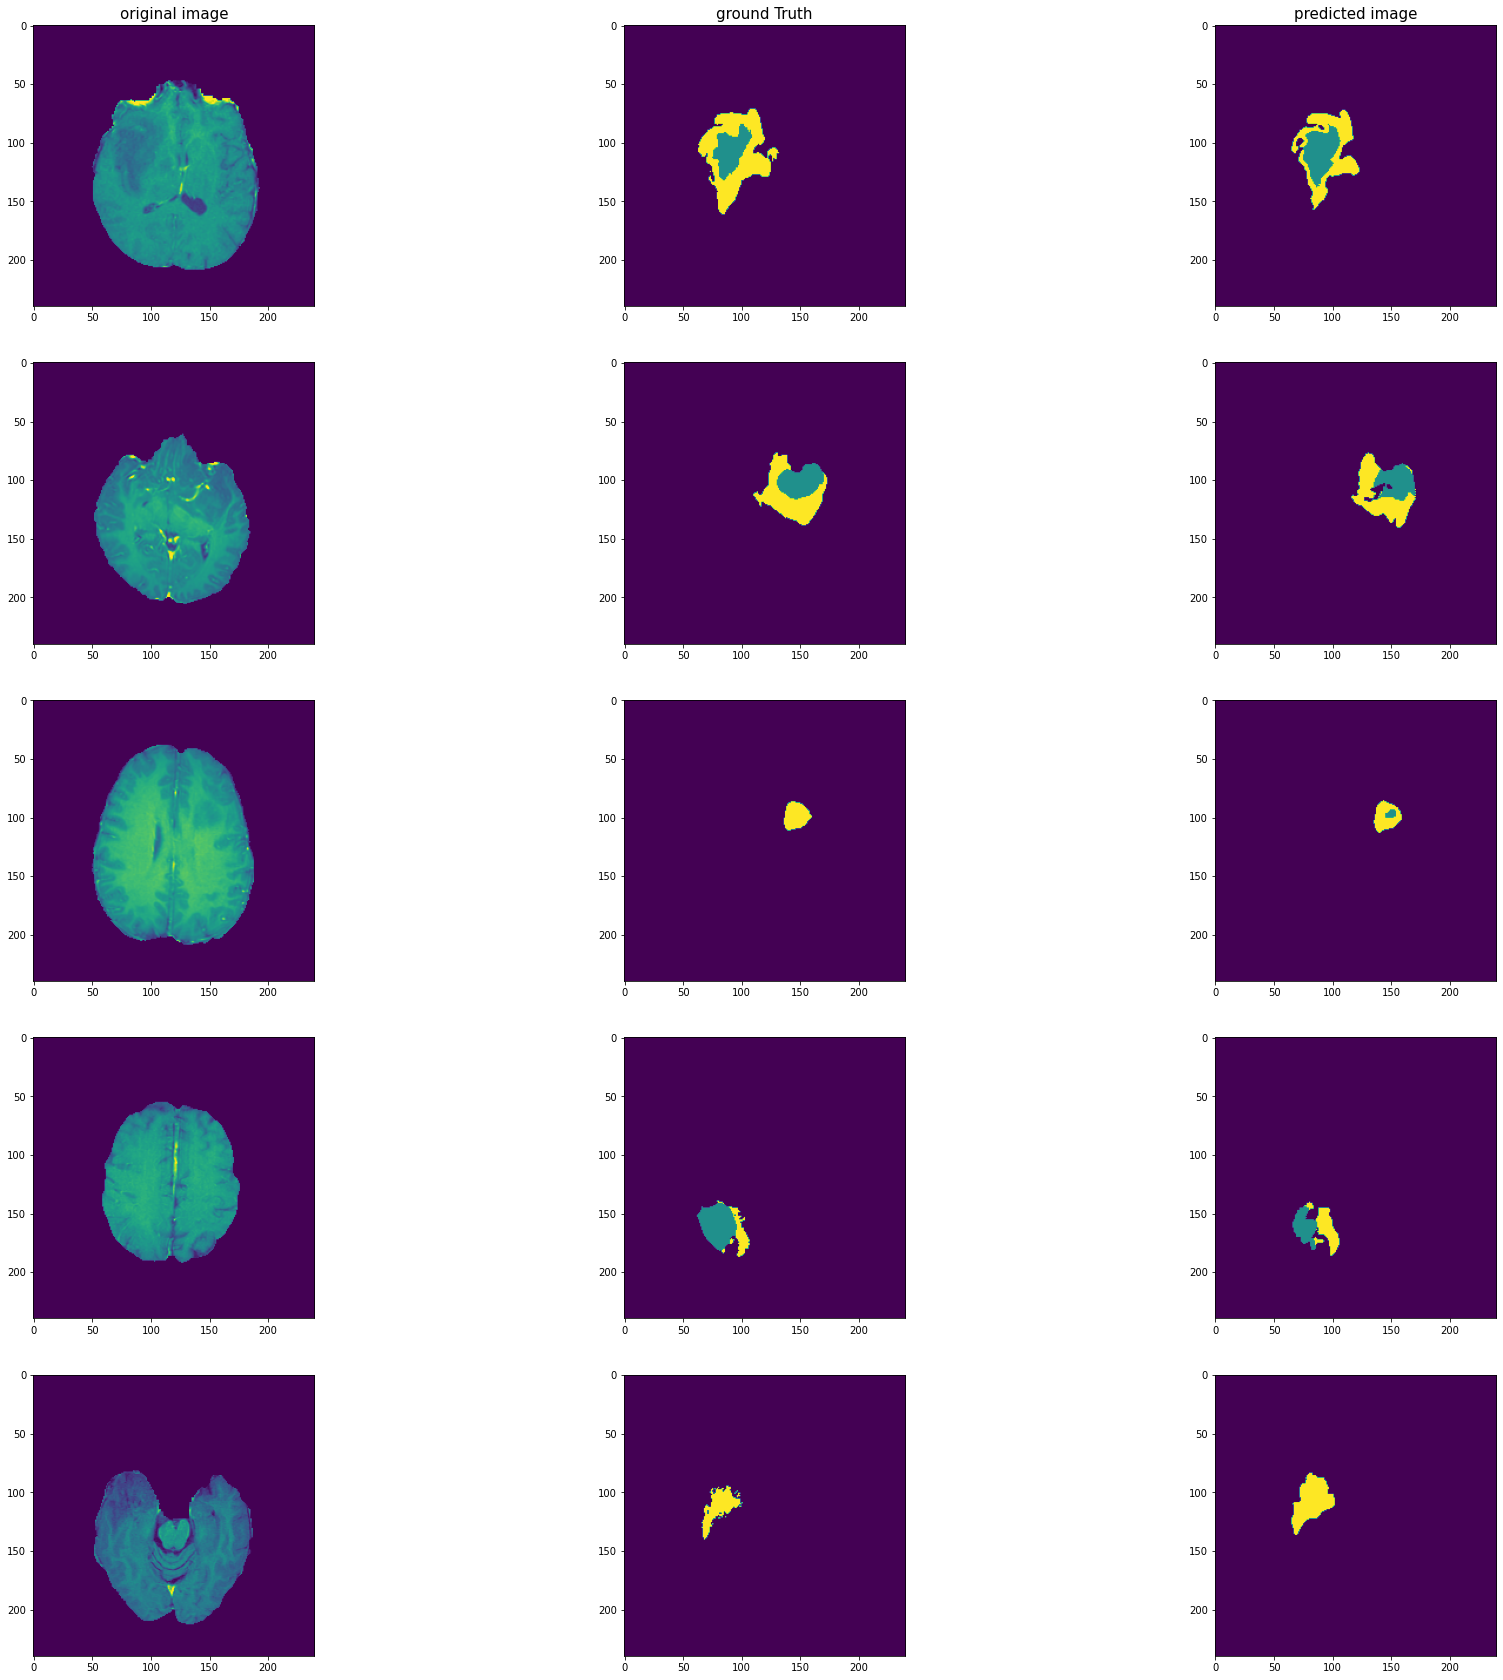

In [ ]:
#plot predictions
k=1
plt.figure(figsize=(30,30))
slice_no=[57,63,85,160,210]
for i in slice_no:
  image,groundtruth,pred_image=predict_(i)
  l=[image[0][:,:,2],groundtruth,pred_image] #taken for a single modality
  for i in l:
    plt.subplot(5,3,k)
    plt.imshow(i)
    if(k==1):
      plt.title("original image",fontdict={"fontsize":15})
    if(k==2):
      plt.title("ground Truth",fontdict={"fontsize":15})
    if(k==3):
      plt.title("predicted image",fontdict={"fontsize":15})
      
    k=k+1


# EXPERIMENTATION TO IMPROVE THE RESULTS

## CANNET BASIC MODEL

In [ ]:

import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:

class stage1(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()


        self.conv=tf.keras.layers.Conv2D(64, kernel_size=(3,3), name='conv', padding="same")
        self.batchn=tf.keras.layers.BatchNormalization( name='bn_conv')
        self.actv=tf.keras.layers.Activation('relu')
        self.maxp=tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2)

    def call(self,X):
        
        #stage1
        op_1=self.conv(X)
        #print(op_1.shape)
        op_2=self.batchn(op_1)
        op_3=self.actv(op_2)
        op_4=self.maxp(op_3)
        
        return op_4


In [ ]:
import tensorflow as tf

class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=2, name="conv block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride

        self.conv1 = tf.keras.layers.Conv2D(self.F1,kernel_size=(1,1),strides=(self.stride,self.stride))
        self.bn1     = tf.keras.layers.BatchNormalization()
        self.bn2     = tf.keras.layers.BatchNormalization()
        self.bn3     = tf.keras.layers.BatchNormalization()
        self.bn4     = tf.keras.layers.BatchNormalization()
        self.act1    = tf.keras.layers.Activation('relu') 
        self.act2    = tf.keras.layers.Activation('relu') 
        self.act3    =tf.keras.layers.Activation('relu')  
        self.act4    =tf.keras.layers.Activation('relu')  
        self.conv2 = tf.keras.layers.Conv2D(self.F2,kernel_size=(3,3),padding='same')
        self.conv3 = tf.keras.layers.Conv2D(self.F3,kernel_size=(1,1))
        self.conv_parallel = tf.keras.layers.Conv2D(self.F3,kernel_size=(3,3),strides=(self.stride,self.stride),padding='same')
        self.add = tf.keras.layers.Add()
    def call(self, X):
        # write the architecutre that was mentioned above

        conv_1 = self.conv1(X)
        bn_1   = self.bn1(conv_1)
        act_1   = self.act1(bn_1)
        conv_2 = self.conv2(act_1)
        bn_2   = self.bn2(conv_2)
        act_2   = self.act2(bn_2)
        conv_3 = self.conv3(act_2)
        bn_3   = self.bn3(conv_3)

        # parallel
        conv_p = self.conv_parallel(X)
        bn_4   = self.bn4(conv_p)
        act_3   = self.act3(bn_4)
        # element wise sum
        ele_sum = self.add([act_3,bn_3])
        
        X = self.act4(ele_sum)

       
        return X



In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv1 = tf.keras.layers.Conv2D(self.F1,kernel_size=(1,1))
        self.bn1     = tf.keras.layers.BatchNormalization()
        self.bn2     = tf.keras.layers.BatchNormalization()
        self.bn3     = tf.keras.layers.BatchNormalization()
        self.bn4     = tf.keras.layers.BatchNormalization()
        self.act1    = tf.keras.layers.Activation('relu') 
        self.act2    = tf.keras.layers.Activation('relu') 
        self.act3    =tf.keras.layers.Activation('relu')  
        self.act4    =tf.keras.layers.Activation('relu')  
        self.conv2 = tf.keras.layers.Conv2D(self.F2,kernel_size=(3,3),padding='same')
        self.conv3 = tf.keras.layers.Conv2D(self.F3,kernel_size=(1,1))
        self.add = tf.keras.layers.Add()
    def call(self, X):
        # write the architecutre that was mentioned above
        conv_1 = self.conv1(X)
        bn_1   = self.bn1(conv_1)
        act_1   = self.act1(bn_1)
        conv_2 = self.conv2(act_1)
        bn_2   = self.bn2(conv_2)
        act_2   = self.act2(bn_2)
        conv_3 = self.conv3(act_2)
        bn_3   = self.bn3(conv_3)
        out=self.add([X,bn_3])
        X=self.act4 (out)

        
        return X

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.glob=tf.keras.layers.GlobalAveragePooling2D()
        self.conv=tf.keras.layers.Conv2D(32,kernel_size=(1,1))
        self.bn=tf.keras.layers.BatchNormalization()
        self.act=tf.keras.layers.Activation('relu')
        self.up=tf.keras.layers.UpSampling2D(size=(28,28),interpolation='bilinear')

    def call(self, X):
        # implement the global flow operatiom
        out=self.glob(X)
        out=tf.expand_dims(out,1)
        out=tf.expand_dims(out,1)
        out1=self.bn(out)
        out2=self.act(out1)
        out3=self.conv(out2)
        X=self.up(out3)


        return X

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)

        self.avg=tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid')
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding='same')
        self.conv2 = tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding='same')
        self.conv3 = tf.keras.layers.Conv2D(32,kernel_size=(1,1))
        self.conv4 = tf.keras.layers.Conv2D(32,kernel_size=(1,1))
        self.act=tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        self.mul=tf.keras.layers.Multiply()
        self.sigmoid=tf.keras.layers.Activation('relu')
        self.up=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
    def call(self, X):
        # here X will a list of two elements 
        #INP, FLOW = X[0], X[1] 
        concat=tf.concat([X[0], X[1]],-1)
        out1=self.avg(concat)
        out2=self.conv1(out1)
        X1=self.conv2(out2)

        output1=self.conv3(X1)
        output2=self.act(output1)
        output3=self.conv4(output2)
        output4=self.sigmoid(output3)

        out_mul=self.mul([X1,output4])
        Y=self.add([out_mul,X1])
        f=self.up(Y)

        
        # implement the context flow as mentioned in the above cell
        return f

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding='same')
        self.glob=tf.keras.layers.GlobalAveragePooling2D()
        self.conv2 = tf.keras.layers.Conv2D(32,kernel_size=(1,1))
        self.bn=tf.keras.layers.BatchNormalization()
        self.sigmoid=tf.keras.layers.Activation('sigmoid')
        self.mul=tf.keras.layers.Multiply()
        self.up=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
    def call(self, X):
        # implement the FSM modules based on image in the above cells

        out_X=self.conv1(X)
        out2=self.glob(out_X)
        out2=tf.expand_dims(out2,1)
        out2=tf.expand_dims(out2,1)
        out3=self.conv2(out2)
        out4=self.bn(out3)
        out_Y=self.sigmoid(out4)

        out=self.mul([out_X,out_Y])
        FSM_Conv_T=self.up(out)

        return FSM_Conv_T

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv2 = tf.keras.layers.Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv3 = tf.keras.layers.Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv4 = tf.keras.layers.Conv2D(32,kernel_size=(7,1),padding='same')
        self.add1 = tf.keras.layers.Add()
        self.add2 = tf.keras.layers.Add()
        self.conv5 = tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding='same')
        
    def call(self, X):
        
        out=self.conv1(X)
        out2=self.conv2(out)

        out_parallel=self.conv3(X)
        out2_parallel=self.conv4(out_parallel)

        out_sum=self.add1([out2,out2_parallel])
        out_x=self.conv5(out_sum)

        X=self.add2([out_x,out_sum])

        return X

In [ ]:
# write the complete architecutre
 #self.avg=tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid')
  #      self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=(3,3),padding='same')
class mymodel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.s1=stage1()
        self.C1=convolutional_block(kernel=3,  filters=[4,4,8], stride=2, name="conv_block1")
        self.C2=convolutional_block(kernel=3,  filters=[8,8,16], stride=2, name="conv_block2")
        self.C3=convolutional_block(kernel=3,  filters=[16,16,32], stride=1, name="conv_block3")
        self.C4=convolutional_block(kernel=3,  filters=[32,32,64], stride=1, name="conv_block4")
        self.I1=identity_block(kernel=3,  filters=[4,4,8], name="identity_block1")
        self.I2=identity_block(kernel=3,  filters=[8,8,16], name="identity_block2")
        self.I3=identity_block(kernel=3,  filters=[8,8,16], name="identity_block3")
        self.I4=identity_block(kernel=3,  filters=[16,16,32], name="identity_block4")
        self.I5=identity_block(kernel=3,  filters=[16,16,32], name="identity_block5")
        self.I6=identity_block(kernel=3,  filters=[16,16,32], name="identity_block6")
        self.I7=identity_block(kernel=3,  filters=[32,32,64], name="identity_block7")
        self.I8=identity_block(kernel=3,  filters=[32,32,64], name="identity_block8")
        self.I9=identity_block(kernel=3,  filters=[32,32,64], name="identity_block9")
        self.I10=identity_block(kernel=3,  filters=[32,32,64], name="identity_block10")

        self.global_f=global_flow(name="global_flow")
        self.context1=context_flow(name="context_flow1")
        self.context2=context_flow(name="context_flow2")
        self.context3=context_flow(name="context_flow3")

        self.add1 = tf.keras.layers.Add()

        self.f_sm=fsm(name="feature_selection")
        self.ag_cn=agcn(name="global_conv_net")

        self.conv = tf.keras.layers.Conv2D(4,kernel_size=(3,3),padding='same')
        self.up=tf.keras.layers.UpSampling2D(size=(4,4),interpolation='bilinear')

        self.softmax=tf.keras.layers.Activation('softmax')

    def call(self, X):

        #stage1
        op_s1=self.s1(X)

        op=self.C1(op_s1)
        op_id=self.I1(op)

        op2=self.C2(op_id)
        op_id2=self.I2(op2)
        op_id3=self.I3(op_id2)

        op3=self.C3(op_id3)
        op_id4=self.I4(op3)
        op_id5=self.I5(op_id4)
        op_id6=self.I6(op_id5)

        op4=self.C4(op_id6)
        op_id7=self.I7(op4)
        op_id8=self.I8(op_id7)
        op_id9=self.I9(op_id8)
        op_c4=self.I10(op_id9)

        op_g=self.global_f(op_c4)
        op_cx1=self.context1([op_c4,op_g])
        op_cx2=self.context2([op_c4,op_cx1])
        op_cx3=self.context3([op_c4,op_cx2])

        op_add=self.add1([op_g,op_cx1,op_cx2,op_cx3])

        op_fsm=self.f_sm(op_add)

        op_agcn=self.ag_cn(op_id)
        op_concat=tf.concat([op_agcn,op_fsm],axis=-1)
        op_conv=self.conv(op_concat)
        op_up=self.up(op_conv)
        Y=self.softmax(op_up)

        return Y


In [ ]:
model=mymodel()

In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3))

In [ ]:
outputs=model(inputs)

In [ ]:
outputs

<tf.Tensor 'mymodel_1/activation_167/truediv:0' shape=(None, 224, 224, 4) dtype=float32>

In [ ]:
model_canet = tf.keras.Model(inputs = inputs, outputs = outputs)

model_canet.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mymodel_1 (mymodel)          (None, 224, 224, 4)       277724    
Total params: 277,724
Trainable params: 275,116
Non-trainable params: 2,608
_________________________________________________________________


In [ ]:
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
learning_rate=0.00000001
model_canet.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])


In [ ]:
# classes for data loading and preprocessing
#to create masks for each patch 
classes=[0,1,2,4]
import numpy as np

from random import sample
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir : path to images folder (directories of all sequences)
        masks_dir : path to segmentation masks folder
        classes : values of classes to extract from segmentation mask

    
    """

    def __init__(
            self, 
            flair_paths,t1_paths,t2_paths,t1ce_paths,mask_paths, 
            
            augmentation=None, 
            classes=classes,
    ):
        self.images_flair =flair_paths
        self.images_t1 =t1_paths
        self.images_t2 =t2_paths
        self.images_t1ce =t1ce_paths
        self.masks_fps =mask_paths
        self.classes=classes
        self.augmentation = augmentation

    def __getitem__(self, i):
        
        # read data
        #print(self.images_flair[i])
        #print(i)
        image_f= np.load(str (self.images_flair[i]))
        image_flair=image_f[8:232,8:232]
        image_1 = np.load(str (self.images_t1[i]))
        image_t1=image_1[8:232,8:232]
        image_1ce = np.load(str (self.images_t1ce[i]))
        image_t1ce=image_1ce[8:232,8:232]
        image_2 = np.load(str (self.images_t2[i]))
        image_t2=image_2[8:232,8:232]
        m = np.load(str (self.masks_fps[i]))
        mask=m[8:232,8:232]

    
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.classes]
        mask = np.stack(masks, axis=-1).astype('float')
        l=[image_flair,image_t1,image_t1ce,image_t2]
        v=[0,1,2,3]
        x,y,z=sample(v,3)

        image=np.stack((l[x],l[y],l[z]), axis=-1).astype('float')

        return image, mask


    def __len__(self):
      return len(self.masks_fps)
    

In [ ]:
import pandas as pd
df=pd.DataFrame()
df['flair']=flair_l
df['t1']=t1_l
df['t1ce']=t1ce_l
df['t2']=t2_l
df['mask']=mask_l


In [ ]:
min_thresh=10005

l=[]
for index,file in enumerate(df['flair']):
  read_file=np.load(file)
  if np.count_nonzero(read_file)>=min_thresh:
    l.append(index)

In [ ]:
new_df=df.iloc[l,:]
new_df.shape

(2890, 5)

In [ ]:
from sklearn.model_selection import train_test_split
X=new_df.drop(["mask"],axis=1)
y=new_df["mask"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
train_data_canet= Dataset(
    flair_paths=list(X_train["flair"]),t1_paths=list(X_train["t1"]),t1ce_paths=list(X_train["t1ce"]),t2_paths=list(X_train["t2"]),mask_paths=list(y_train),
    classes=classes
  
)

test_data_canet= Dataset(
    flair_paths=list(X_test["flair"]),t1_paths=list(X_test["t1"]),t1ce_paths=list(X_test["t1ce"]),t2_paths=list(X_test["t2"]),mask_paths=list(y_test),
    classes=classes
  
)

In [ ]:
train_dataloader_canet = Dataloder(train_data_canet, batch_size=4, shuffle=True)
valid_dataloader_canet = Dataloder(test_data_canet, batch_size=1, shuffle=True)

# check shapes for errors
assert train_dataloader_canet[0][0].shape == (4, 224, 224, 3)
assert train_dataloader_canet[0][1].shape == (4, 224, 224, 4)

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint_reducelr = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/cannet2/weights-{epoch:02d}-{val_iou_score:.4f}.hdf5', monitor='val_iou_score',save_weights_only = True,  verbose=1, save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_iou_score', factor=0.8, patience=3, verbose=0, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
),
]

In [ ]:
%load_ext tensorboard
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
log_dir="logs/fit/basic-canet" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
model_canet.load_weights("/content/drive/My Drive/cannet2/model_cannet500-1.h5")

In [ ]:
history = model_canet.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),epochs=10,validation_data=valid_dataloader,callbacks=checkpoint_reducelr)

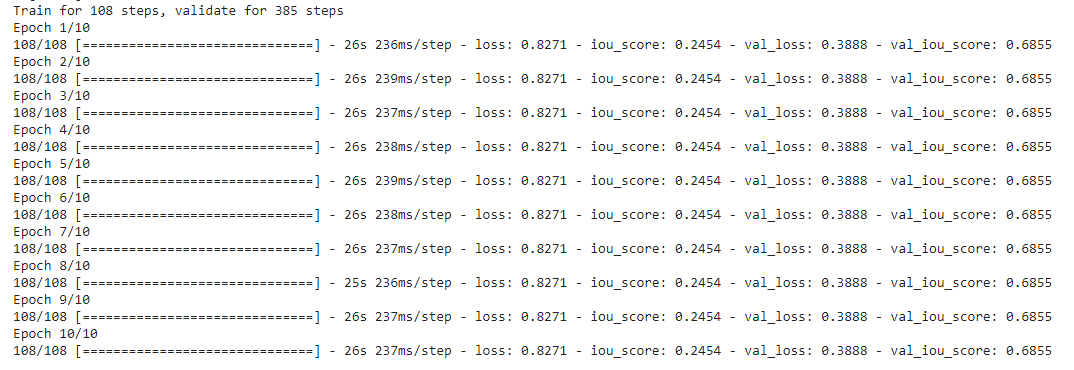

In [ ]:
#here by using the basic cannet we can observe there is no change in loss,clearly indicating that weights are not getting updated-vanishing gradients
#so next experiment i've used is by removing the identity blocks so to reduce some layers which trades with vanishing gradients

## CANNET MODEL-WITHOUT IDENTITY BLOCKS

In [ ]:
#cannet model-Removed identity blocks 

class mymodel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.s1=stage1()
        self.C1=convolutional_block(kernel=3,  filters=[4,4,8], stride=2, name="conv_block1")
        self.C2=convolutional_block(kernel=3,  filters=[8,8,16], stride=2, name="conv_block2")
        self.C3=convolutional_block(kernel=3,  filters=[16,16,32], stride=1, name="conv_block3")
        self.C4=convolutional_block(kernel=3,  filters=[32,32,64], stride=1, name="conv_block4")
        self.I1=identity_block(kernel=3,  filters=[4,4,8], name="identity_block1")
        self.I2=identity_block(kernel=3,  filters=[8,8,16], name="identity_block2")
        #self.I3=identity_block(kernel=3,  filters=[32,32,64], name="identity_block3")
        self.I4=identity_block(kernel=3,  filters=[16,16,32], name="identity_block4")
        #self.I5=identity_block(kernel=3,  filters=[64,64,128], name="identity_block5")
        #self.I6=identity_block(kernel=3,  filters=[64,64,128], name="identity_block6")
        self.I7=identity_block(kernel=3,  filters=[32,32,64], name="identity_block7")
        #self.I8=identity_block(kernel=3,  filters=[128,128,256], name="identity_block8")
        #self.I9=identity_block(kernel=3,  filters=[128,128,256], name="identity_block9")
        self.I10=identity_block(kernel=3,  filters=[32,32,64], name="identity_block10")

        self.global_f=global_flow(name="global_flow")
        self.context1=context_flow(name="context_flow1")
        self.context2=context_flow(name="context_flow2")
        self.context3=context_flow(name="context_flow3")

        self.add1 = tf.keras.layers.Add()

        self.f_sm=fsm(name="feature_selection")
        self.ag_cn=agcn(name="global_conv_net")

        self.conv = tf.keras.layers.Conv2D(4,kernel_size=(3,3),padding='same')
        self.up=tf.keras.layers.UpSampling2D(size=(4,4),interpolation='bilinear')

        self.softmax=tf.keras.layers.Activation('softmax')

    def call(self, X):

        #stage1
        op_s1=self.s1(X)

        op=self.C1(op_s1)
        op_id=self.I1(op)

        op2=self.C2(op_id)
        op_id2=self.I2(op2)
        #op_id3=self.I3(op_id2)

        op3=self.C3(op_id2)
        op_id4=self.I4(op3)
        #op_id5=self.I5(op_id4)
        #op_id6=self.I6(op_id5)

        op4=self.C4(op_id4)
        op_id7=self.I7(op4)
        #op_id8=self.I8(op_id7)
        #op_id9=self.I9(op_id8)
        op_c4=self.I10(op_id7)

        op_g=self.global_f(op_c4)
        op_cx1=self.context1([op_c4,op_g])
        op_cx2=self.context2([op_c4,op_cx1])
        op_cx3=self.context3([op_c4,op_cx2])

        op_add=self.add1([op_g,op_cx1,op_cx2,op_cx3])

        op_fsm=self.f_sm(op_add)

        op_agcn=self.ag_cn(op_id)
        op_concat=tf.concat([op_agcn,op_fsm],axis=-1)
        op_conv=self.conv(op_concat)
        op_up=self.up(op_conv)
        Y=self.softmax(op_up)

        return Y


In [ ]:
model=mymodel()

In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3))

In [ ]:
outputs=model(inputs)

In [ ]:
outputs

<tf.Tensor 'mymodel_2/activation_213/truediv:0' shape=(None, 224, 224, 4) dtype=float32>

In [ ]:
model_canet_no_id = tf.keras.Model(inputs = inputs, outputs = outputs)

model_canet_no_id.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mymodel_2 (mymodel)          (None, 224, 224, 4)       241532    
Total params: 241,532
Trainable params: 239,756
Non-trainable params: 1,776
_________________________________________________________________


In [ ]:
learning_rate=0.00000001
model_canet_no_id.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])


In [ ]:
train_dataloader_canet_no_id = Dataloder(train_data_canet, batch_size=4, shuffle=True)
valid_dataloader_canet_no_id = Dataloder(test_data_canet, batch_size=1, shuffle=True)

# check shapes for errors
assert train_dataloader_canet_no_id[0][0].shape == (4, 224, 224, 3)
assert train_dataloader_canet_no_id[0][1].shape == (4, 224, 224, 4)

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint_reducelr = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/cannet-weights/weights-{epoch:02d}-{val_iou_score:.4f}.hdf5', monitor='val_iou_score',  verbose=1, save_best_only=True, mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.08, patience=3, verbose=0, mode='min',
    min_delta=0.0001, cooldown=0, min_lr=0
),tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0.0001, patience=2, verbose=0, mode='min')
]

In [ ]:
#model_canet_no_id.load_weights("/content/drive/My Drive/cannet-weights")

In [ ]:
%load_ext tensorboard
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
log_dir="logs/fit/canet-no-id" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
history = model_canet_no_id.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),epochs=500,validation_data=valid_dataloader,callbacks=checkpoint_reducelr)

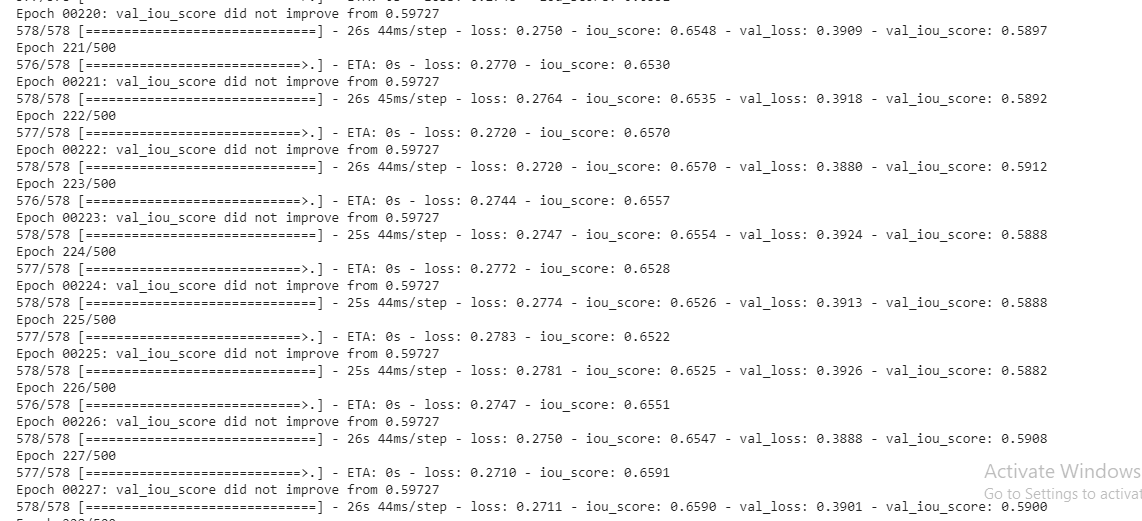

In [ ]:
#validation dice loss got stuck at 0.3900 for around 15 epochs the model is not learning more,may be with too many parameters
#all the parameters are not able to change accordingly so that loss is not converging even running for about 220 eppochs.

# EXPERIMENTATION OF BACKBONE NETWORKS

## RESNET152

In [ ]:
#Here resnet152 network is used for classificaion task so to check if the model performance is good or not
#if the performance is good that represents context information of image is well captured in final pre-trained layers 

In [ ]:
IMAGE_SIZE=[224,224]
res=tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMAGE_SIZE + [3],
    pooling=None,
    classes=2
)#without fc layers

from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
import matplotlib.pyplot as plt
import random as rn

for layer in res.layers:
  layer.trainable = False

#Conv Layer
Conv = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=32),name='Conv')(res.output)
#MaxPool Layer
Pool = MaxPool2D(pool_size=(2,2),strides=(1,1),padding='valid',name='Pool')(Conv)


#Flatten
flatten = Flatten(name='Flatten')(Pool)

#FC1 layer
FC1 = Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)

#FC2 layer
FC2 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC2')(FC1)

#FC3 layer
FC3 = Dense(units=32,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC3')(FC2)

#FC4 layer
#FC4 = Dense(units=16,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC4')(FC3)

#output layer
Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='Output')(FC3)

#Creating a model
model_res = Model(inputs=res.input,outputs=Out)

In [ ]:
model_res.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),loss='binary_crossentropy',metrics=['accuracy'])
model_res.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
history = model_res.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),epochs=500,validation_data=valid_dataloader)


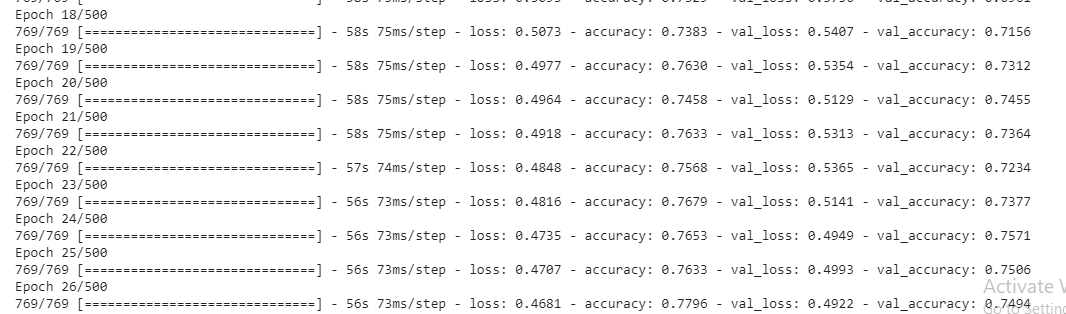

In [ ]:
#model is converging well,loss is reducing slowly but there is convergence we can try this architecture as back bone for cannet 

### VGG16

In [ ]:
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
import matplotlib.pyplot as plt
import random as rn


IMAGE_SIZE=[224,224]
vg=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMAGE_SIZE + [3],
    pooling=None,
    classes=2
)#without fc layers



for layer in vg.layers:
  layer.trainable = False

#Conv Layer
Conv = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=32),name='Conv')(res.output)
#MaxPool Layer
Pool = MaxPool2D(pool_size=(2,2),strides=(1,1),padding='valid',name='Pool')(Conv)


#Flatten
flatten = Flatten(name='Flatten')(Pool)

#FC1 layer
FC1 = Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)

#FC2 layer
FC2 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC2')(FC1)

#FC3 layer
FC3 = Dense(units=32,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC3')(FC2)

#FC4 layer
#FC4 = Dense(units=16,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC4')(FC3)

#output layer
Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='Output')(FC3)

#Creating a model
model_vg = Model(inputs=res.input,outputs=Out)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vg.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),loss='binary_crossentropy',metrics=['accuracy'])
model_vg.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
history = model_vg.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),epochs=500,validation_data=valid_dataloader)


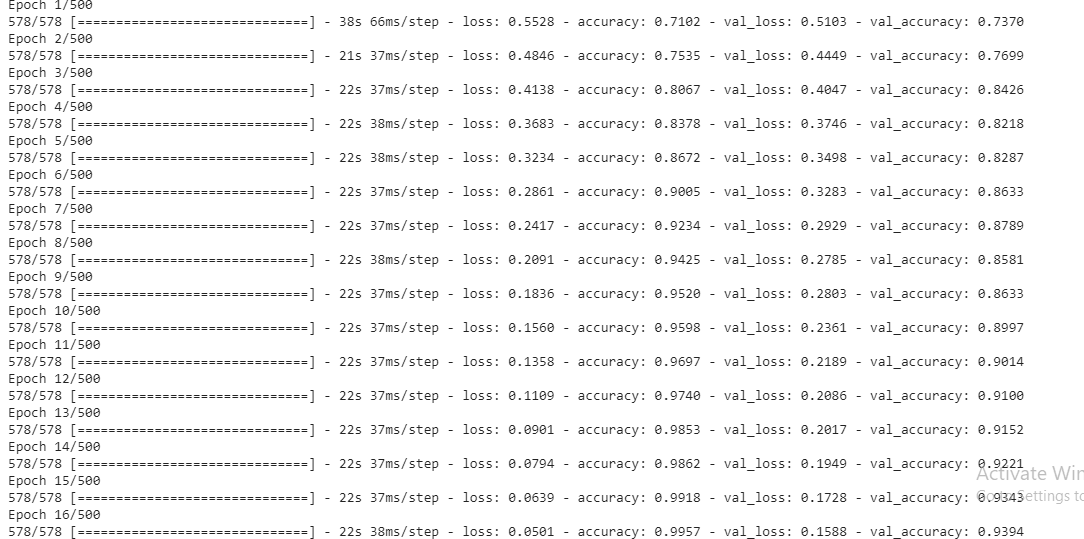

In [ ]:
#model is converging very quickly better than resnet so vgg pretrained layer weights capture better context of image than resnet
#so we can add vgg as backbone without training

## CANNET WITH VGG BACKBONE

In [ ]:
#Replacining Conv blocks and identity blocks fromm cannet architecture with vgg retrained architecture and giving 14,14 layer (of vgg block5 conv3) (context of image/global  features)as input to
#global blocks and context flow modules and using augmentation techinques

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.glob=tf.keras.layers.GlobalAveragePooling2D()
        self.conv=tf.keras.layers.Conv2D(64,kernel_size=(1,1))
        self.bn=tf.keras.layers.BatchNormalization()
        self.act=tf.keras.layers.Activation('relu')
        self.up=tf.keras.layers.UpSampling2D(size=(7,7),interpolation='bilinear')

    def call(self, X):
        # implement the global flow operatiom
        out=self.glob(X)
        out=tf.expand_dims(out,1)
        out=tf.expand_dims(out,1)
        out1=self.bn(out)
        out2=self.act(out1)
        out3=self.conv(out2)
        X=self.up(out3)


        return X

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)

        self.avg=tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=1, padding='same')
        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')
        self.conv3 = tf.keras.layers.Conv2D(64,kernel_size=(1,1))
        self.conv4 = tf.keras.layers.Conv2D(64,kernel_size=(1,1))
        self.act=tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        self.mul=tf.keras.layers.Multiply()
        self.sigmoid=tf.keras.layers.Activation('relu')
        #self.up=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')
    def call(self, X):
        # here X will a list of two elements 
        #INP, FLOW = X[0], X[1] 
        concat=tf.concat([X[0], X[1]],-1)

        #print("concat",concat.shape)
        out1=self.avg(concat)
        #print("out1",out1.shape)
        out2=self.conv1(out1)
        X1=self.conv2(out2)

        output1=self.conv3(X1)
        output2=self.act(output1)
        output3=self.conv4(output2)
        output4=self.sigmoid(output3)
        #print("x1",X1.shape)
        #print("oup4",output4.shape)
        out_mul=self.mul([X1,output4])
        Y=self.add([out_mul,X1])
        #f=self.up(Y)
        #print("up",f.shape)

        
        # implement the context flow as mentioned in the above cell
        return Y

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')
        self.glob=tf.keras.layers.GlobalAveragePooling2D()
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=(1,1))
        self.bn=tf.keras.layers.BatchNormalization()
        self.sigmoid=tf.keras.layers.Activation('sigmoid')
        self.mul=tf.keras.layers.Multiply()
        self.up=tf.keras.layers.UpSampling2D(size=(16,16),interpolation='bilinear')
    def call(self, X):
        # implement the FSM modules based on image in the above cells

        out_X=self.conv1(X)
        out2=self.glob(out_X)
        out2=tf.expand_dims(out2,1)
        out2=tf.expand_dims(out2,1)
        out3=self.conv2(out2)
        out4=self.bn(out3)
        out_Y=self.sigmoid(out4)

        out=self.mul([out_X,out_Y])
        FSM_Conv_T=self.up(out)

        return FSM_Conv_T

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=(7,1),padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=(1,7),padding='same')
        self.conv3 = tf.keras.layers.Conv2D(64,kernel_size=(1,7),padding='same')
        self.conv4 = tf.keras.layers.Conv2D(64,kernel_size=(7,1),padding='same')
        self.add1 = tf.keras.layers.Add()
        self.add2 = tf.keras.layers.Add()
        self.conv5 = tf.keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')
        
    def call(self, X):
        
        out=self.conv1(X)
        out2=self.conv2(out)

        out_parallel=self.conv3(X)
        out2_parallel=self.conv4(out_parallel)

        out_sum=self.add1([out2,out2_parallel])
        out_x=self.conv5(out_sum)

        X=self.add2([out_x,out_sum])

        return X

In [ ]:
        
        IMAGE_SIZE=[224,224]
        vgg=VGG16(include_top=False,weights="imagenet",input_shape=IMAGE_SIZE + [3]) #without fc layers

        for layer in vgg.layers:
          layer.trainable = False

        #train layer 14
        vgg.get_layer('block5_conv3').trainable=True
        
        c1 = vgg.get_layer('block2_conv2').output
        vgg_op=vgg.get_layer('block5_conv3').output
        
        op_g=global_flow(name="global_flow")(vgg_op)

        op_cx1=context_flow(name="context_flow1")([vgg.output,op_g])
        op_cx2=context_flow(name="context_flow2")([vgg.output,op_cx1])
        op_cx3=context_flow(name="context_flow3")([vgg.output,op_cx2])

        op_add=tf.keras.layers.Add()([op_g,op_cx1,op_cx2,op_cx3])

        op_fsm=fsm(name="feature_selection")(op_add)
      


        op_agcn=agcn(name="global_conv_net")(c1)

        op_concat=tf.concat([op_agcn,op_fsm],axis=-1)
        op_conv=tf.keras.layers.Conv2D(4,kernel_size=(3,3),padding='same')(op_concat)
        op_up=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')(op_conv)
        Y_vgg_aug=tf.keras.layers.Activation('softmax')(op_up)

In [ ]:
Y_vgg_aug.shape

TensorShape([None, 224, 224, 4])

In [ ]:
model_vgg_aug = tf.keras.Model(inputs = vgg.input,outputs=Y_vgg_aug)

model_vgg_aug.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________

In [ ]:
learning_rate=0.0000001
model_vgg_aug.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:
import pandas as pd
df=pd.DataFrame()
df['flair']=flair_l
df['t1']=t1_l
df['t1ce']=t1ce_l
df['t2']=t2_l
df['mask']=mask_l


In [ ]:
min_thresh=10005

l=[]
for index,file in enumerate(df['flair']):
  read_file=np.load(file)
  if np.count_nonzero(read_file)>=min_thresh:
    l.append(index)

In [ ]:
new_df=df.iloc[l,:]

In [ ]:
import imgaug.augmenters as iaa
#import imgaug

aug1 = iaa.Flipud(1)
aug2 = iaa.DirectedEdgeDetect(alpha=(0.5))


In [ ]:
# classes for data loading and preprocessing
#to create masks for each patch 
classes=[0,1,2,4]
import numpy as np

from random import sample
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir : path to images folder (directories of all sequences)
        masks_dir : path to segmentation masks folder
        classes : values of classes to extract from segmentation mask

    
    """

    def __init__(
            self, 
            flair_paths,t1_paths,t1ce_paths,mask_paths, 
            
            augmentation=None, 
            classes=classes,
    ):
        self.images_flair =flair_paths
        self.images_t1 =t1_paths
        #self.images_t2 =t2_paths
        self.images_t1ce =t1ce_paths
        self.masks_fps =mask_paths
        self.classes=classes
        self.augmentation = augmentation

    def __getitem__(self, i):
        
        # read data
        #print(self.images_flair[i])
        #print(i)
        image_f= np.load(str (self.images_flair[i]))
        image_flair=image_f[8:232,8:232]
        image_1 = np.load(str (self.images_t1[i]))
        image_t1=image_1[8:232,8:232]
        image_1ce = np.load(str (self.images_t1ce[i]))
        image_t1ce=image_1ce[8:232,8:232]
        #image_2 = np.load(str (self.images_t2[i]))
        #image_t2=image_2[8:232,8:232]
        m = np.load(str (self.masks_fps[i]))
        mask=m[8:232,8:232]
        #mask=self.masks_fps[i]

    
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.classes]
        mask = np.stack(masks, axis=-1).astype('float')
        #l=[image_flair,image_t1,image_t1ce]
        #v=[0,1,2,3]
        #x,y,z=sample(v,3)

        image=np.stack((image_flair,image_t1,image_t1ce), axis=-1).astype('float')

        # apply augmentations

        image = aug1.augment_image(image)
        mask = aug1.augment_image(mask)
        
        image = aug2.augment_image(image)        

        return image,mask


    def __len__(self):
      return len(self.masks_fps)
    

In [ ]:
mask_class=[]
for i in new_df['mask']:
  if np.load(i).any()>0:
    mask_class.append(1)
  else:
    mask_class.append(0)

new_df['mask_class']=mask_class

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from sklearn.model_selection import train_test_split
X=new_df.drop(["mask","t2"],axis=1)
y=new_df["mask"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=mask_class,test_size=0.2,random_state=10)

In [ ]:
train_data_vgg_aug= Dataset(
    flair_paths=list(X_train["flair"]),t1_paths=list(X_train["t1"]),t1ce_paths=list(X_train["t1ce"]),mask_paths=list(y_train),
    classes=classes
  
)

test_data_vgg_aug= Dataset(
    flair_paths=list(X_test["flair"]),t1_paths=list(X_test["t1"]),t1ce_paths=list(X_test["t1ce"]),mask_paths=list(y_test),
    classes=classes
  
)

In [ ]:
train_dataloader_vgg_aug = Dataloder(train_data_vgg_aug, batch_size=4, shuffle=True)
valid_dataloader_vgg_aug = Dataloder(test_data_vgg_aug, batch_size=1, shuffle=True)

# check shapes for errors
assert train_dataloader_vgg_aug[0][0].shape == (4, 224, 224, 3)
assert train_dataloader_vgg_aug[0][1].shape == (4, 224, 224, 4)

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint_reducelr = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/cannet-vgg-14train-edge-lgg/weights-{epoch:02d}-{val_dice_coef:.4f}.hdf5', monitor='val_dice_coef',save_weights_only = True,  verbose=1, save_best_only=True, mode='max'),
]

In [ ]:
#model_vgg_aug.load_weights("/content/drive/My Drive/cannet-vgg-14train-edge-lgg/weights-112-0.6273.hdf5")

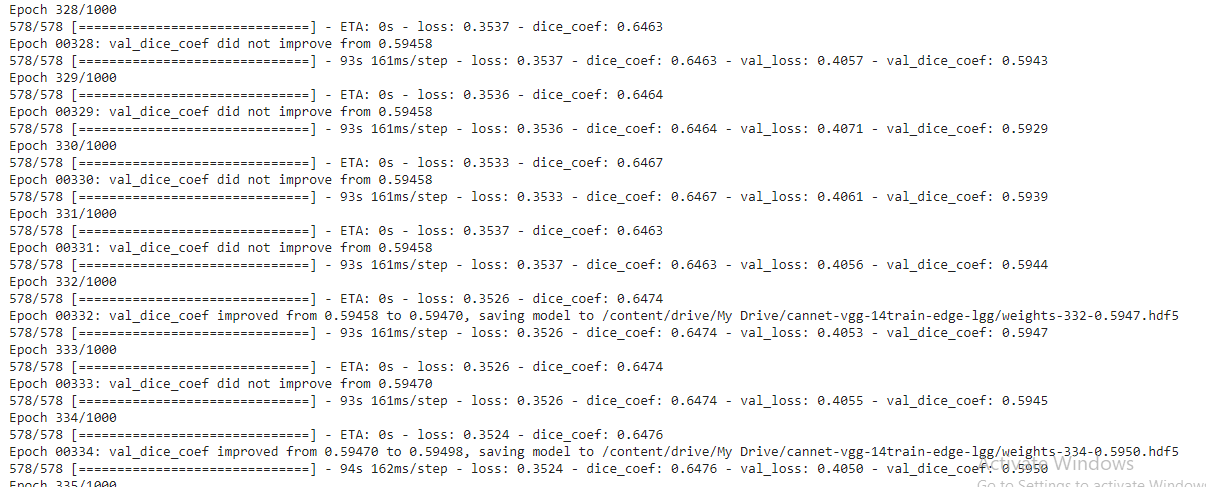

In [ ]:
#using augmentation tecnique the model has dice coeff as 0.6273 as already we are using pretrained vgg16 as transfer learning technique
#so we can check without augmentation technique 

## CANNET USING VGG BACKBONE-WITHOUT AUGMENTATION TECHNIQUE

In [ ]:
        IMAGE_SIZE=[224,224]
        vgg=VGG16(include_top=False,weights="imagenet",input_shape=IMAGE_SIZE + [3]) #without fc layers

        for layer in vgg.layers:
          layer.trainable = False
        
        c1 = vgg.get_layer('block2_conv2').output
        vgg_op=vgg.get_layer('block5_conv3').output
        
        op_g=global_flow(name="global_flow")(vgg_op)

        op_cx1=context_flow(name="context_flow1")([vgg.output,op_g])
        op_cx2=context_flow(name="context_flow2")([vgg.output,op_cx1])
        op_cx3=context_flow(name="context_flow3")([vgg.output,op_cx2])

        op_add=tf.keras.layers.Add()([op_g,op_cx1,op_cx2,op_cx3])

        op_fsm=fsm(name="feature_selection")(op_add)
      


        op_agcn=agcn(name="global_conv_net")(c1)

        op_concat=tf.concat([op_agcn,op_fsm],axis=-1)
        op_conv=tf.keras.layers.Conv2D(4,kernel_size=(3,3),padding='same')(op_concat)
        op_up=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear')(op_conv)
        Y_vgg=tf.keras.layers.Activation('softmax')(op_up)

In [ ]:
Y_vgg.shape

TensorShape([None, 224, 224, 4])

In [ ]:
model_vgg = tf.keras.Model(inputs = vgg.input,outputs=Y_vgg)
learning_rate=0.000001
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])
model_vgg.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________

In [ ]:
tf.compat.v1.enable_eager_execution()

In [ ]:
# classes for data loading and preprocessing
#to create masks for each patch 
classes=[0,1,2,4]
import numpy as np

from random import sample
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir : path to images folder (directories of all sequences)
        masks_dir : path to segmentation masks folder
        classes : values of classes to extract from segmentation mask

    
    """

    def __init__(
            self, 
            flair_paths,t1_paths,t1ce_paths,mask_paths, 
            
            augmentation=None, 
            classes=classes,
    ):
        self.images_flair =flair_paths
        self.images_t1 =t1_paths
        #self.images_t2 =t2_paths
        self.images_t1ce =t1ce_paths
        self.masks_fps =mask_paths
        self.classes=classes
        self.augmentation = augmentation

    def __getitem__(self, i):
        
        # read data
        #print(self.images_flair[i])
        #print(i)
        image_f= np.load(str (self.images_flair[i]))
        image_flair=image_f[8:232,8:232]
        image_1 = np.load(str (self.images_t1[i]))
        image_t1=image_1[8:232,8:232]
        image_1ce = np.load(str (self.images_t1ce[i]))
        image_t1ce=image_1ce[8:232,8:232]
        #image_2 = np.load(str (self.images_t2[i]))
        #image_t2=image_2[8:232,8:232]
        m = np.load(str (self.masks_fps[i]))
        mask=m[8:232,8:232]
        #mask=self.masks_fps[i]

    
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.classes]
        mask = np.stack(masks, axis=-1).astype('float')
        #l=[image_flair,image_t1,image_t1ce]
        #v=[0,1,2,3]
        #x,y,z=sample(v,3)

        image=np.stack((image_flair,image_t1,image_t1ce), axis=-1).astype('float')

        return image,mask


    def __len__(self):
      return len(self.masks_fps)
    

In [ ]:
from sklearn.model_selection import train_test_split
X=new_df.drop(["mask","t2"],axis=1)
y=new_df["mask"]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
train_data_vgg= Dataset(
    flair_paths=list(X_train["flair"]),t1_paths=list(X_train["t1"]),t1ce_paths=list(X_train["t1ce"]),mask_paths=list(y_train),
    classes=classes
  
)

test_data_vgg= Dataset(
    flair_paths=list(X_test["flair"]),t1_paths=list(X_test["t1"]),t1ce_paths=list(X_test["t1ce"]),mask_paths=list(y_test),
    classes=classes
  
)

In [ ]:
train_dataloader_vgg = Dataloder(train_data_vgg, batch_size=4, shuffle=True)
valid_dataloader_vgg = Dataloder(test_data_vgg, batch_size=1, shuffle=True)

# check shapes for errors
assert train_dataloader_vgg[0][0].shape == (4, 224, 224, 3)
assert train_dataloader_vgg[0][1].shape == (4, 224, 224, 4)

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
checkpoint_reducelr = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/cannet-vgg-14/weights-{epoch:02d}-{val_dice_coef:.4f}.hdf5', monitor='val_dice_coef',save_weights_only = True,  verbose=1, save_best_only=True, mode='max'),
]

In [ ]:
model_vgg.load_weights("/content/drive/My Drive/cannet-vgg-14/weights-331-0.7672.hdf5")

In [ ]:
history = model_vgg.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader),epochs=500,validation_data=valid_dataloader,callbacks=checkpoint_reducelr)

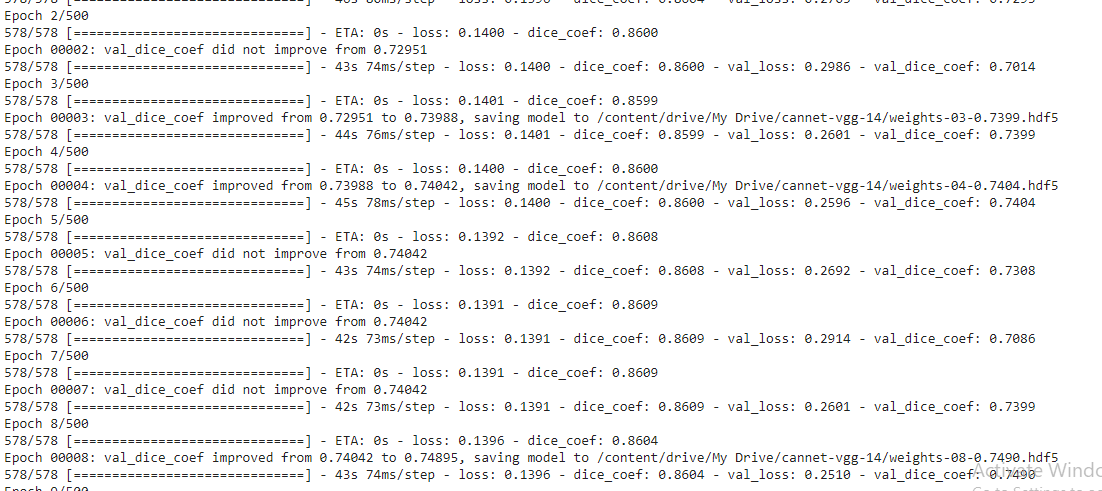

In [ ]:
#Out of all the experiments cannet with pretrained vgg backbone got generelized well and acheived high dice coefficent compared to base line unet model
# also trainable parameters are also very low having less computational cost
#Major advantage of using this network is basline unet has 138 million parameter where as our architecture have only around 1.5 million parameters

In [ ]:
#prediction
def predict_(slice_):
  #image
  img_data=valid_dataloader_vgg[slice_]
  image=img_data[0]# original image
  

  #ground truth image
  ground_truth=img_data[1][0]
  ground_truth=np.argmax(ground_truth,axis=-1)
  print("unique_classes in ground truth :",np.unique(ground_truth))
  

  #predicted image
  
  pred_img=model_vgg.predict(image)
  pred_img=np.argmax(pred_img[0],axis=-1)
  print("unique_classes in predicted image :",np.unique(pred_img))

  return image,ground_truth,pred_img



unique_classes in ground truth : [0 1 2]
unique_classes in predicted image : [0 1 2]
unique_classes in ground truth : [0 2]
unique_classes in predicted image : [0 2]
unique_classes in ground truth : [0 2]
unique_classes in predicted image : [0 2]
unique_classes in ground truth : [0 1 2 3]
unique_classes in predicted image : [0 1 2 3]
unique_classes in ground truth : [0 1 2]
unique_classes in predicted image : [0 1 2]


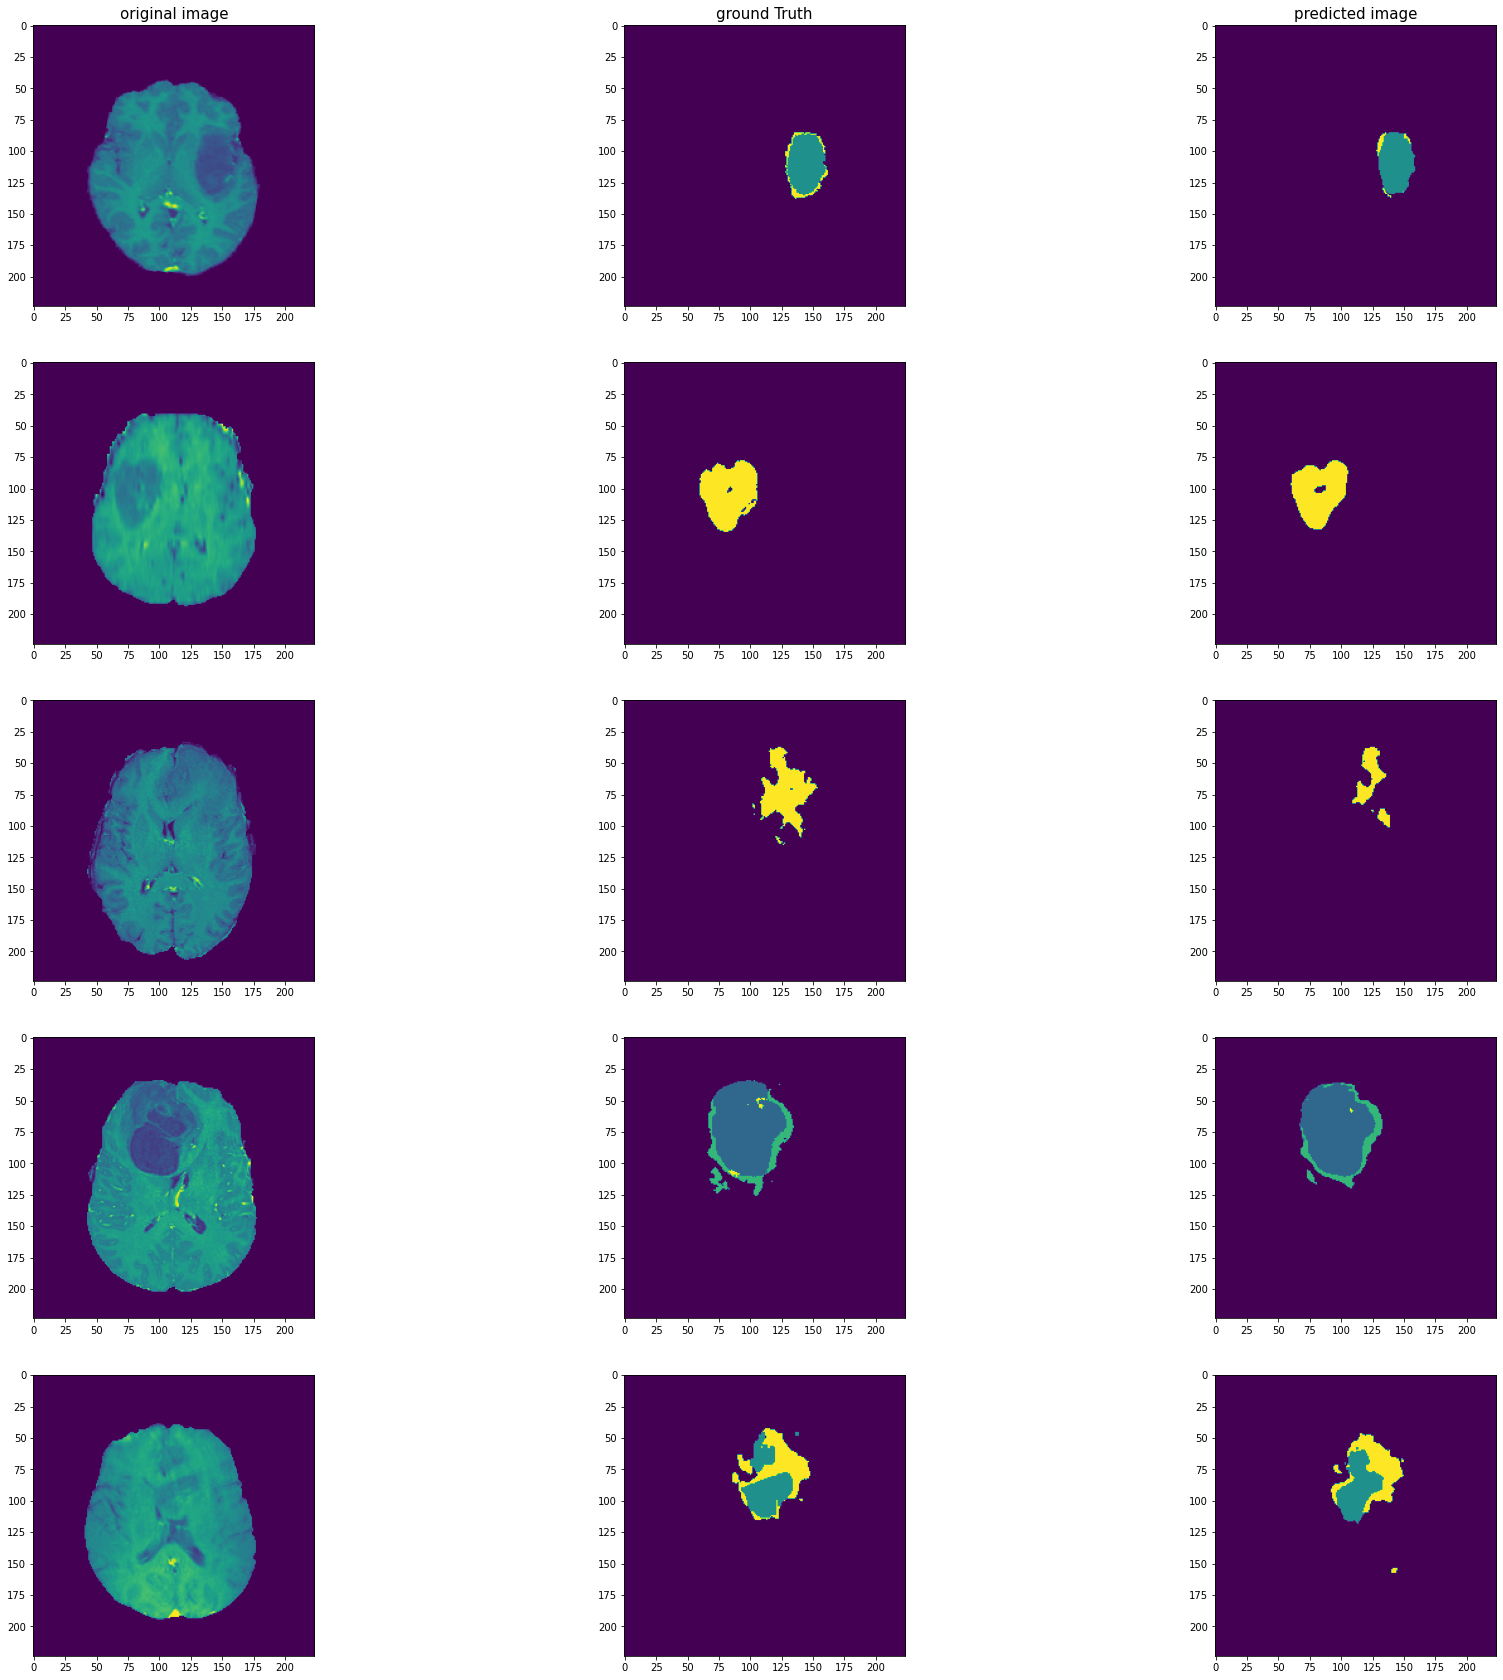

In [ ]:
#prediction of cannet model-vgg backbone
k=1
plt.figure(figsize=(30,30))
slice_no=[140,196,116,126,19]
for i in slice_no:
  image,groundtruth,pred_image=predict_(i)
  l=[image[0][:,:,2],groundtruth,pred_image] #taken for a single modality
  for i in l:
    plt.subplot(5,3,k)
    plt.imshow(i)
    if(k==1):
      plt.title("original image",fontdict={"fontsize":15})
    if(k==2):
      plt.title("ground Truth",fontdict={"fontsize":15})
    if(k==3):
      plt.title("predicted image",fontdict={"fontsize":15})
      
    k=k+1


In [ ]:

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","trainable parameters","dice coeff"]


x.add_row(["Baseline-Unet Model",  "138m" , 0.7679])
x.add_row(["Basic Cannet Model", "275k" , "vanishing gradients"])
x.add_row(["Cannet without Identity Blocks", "239k", 0.68])
x.add_row(["Cannet using VGG Backbone-With Augmentation", "3m" , 0.6273])
x.add_row(["Cannet using VGG Backbone-Without Augmentation", "1.4m",0.7672])

print(x)

+------------------------------------------------+----------------------+---------------------+
|                     Model                      | trainable parameters |      dice coeff     |
+------------------------------------------------+----------------------+---------------------+
|              Baseline-Unet Model               |         138m         |        0.7679       |
|               Basic Cannet Model               |         275k         | vanishing gradients |
|         Cannet without Identity Blocks         |         239k         |         0.68        |
|  Cannet using VGG Backbone-With Augmentation   |          3m          |        0.6273       |
| Cannet using VGG Backbone-Without Augmentation |         1.4m         |        0.7672       |
+------------------------------------------------+----------------------+---------------------+


#### Here compared to all the models, final architecture which I've used for segmenting the tumor is CANNET Architecture using VGG16 as Backbone network without the augmentation techniques
